In [1]:
#import the neccesary libraries
from datetime import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import time
import matplotlib as mpl
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import re
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from chart_studio import plotly
from plotly import tools
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
import shap
from textblob import TextBlob
import string, os, random
from textstat import flesch_reading_ease
from nltk.corpus import stopwords
from sklearn.metrics import silhouette_score
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from fbprophet import Prophet
import numpy as np
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
words = set(nltk.corpus.words.words())
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import snscrape.modules.twitter as sntwitter

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False
pd.set_option('display.max_columns', None)
from datetime import datetime,timedelta

/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/hyacinthampadu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hyacinthampadu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#database login
Db_host='127.0.0.1'
Db_name='postgres'
Db_user='postgres'
Db_pass='Brunei42i'

In [3]:
#connect to postgres database
conn = psycopg2.connect(host=Db_host, dbname=Db_name, user=Db_user,password=Db_pass)
conn.set_session(autocommit=True)
cur = conn.cursor()

In [4]:
#obtain financial data from database
parallel=pd.read_sql_query("SELECT * FROM parallel_trades",conn)
parallel.head()

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


,chain,collectionaddress,collectionname,exchange,logindex,maker,price,quotecurrency,side,taker,thumbnailurl,timestamp,tokenid,tx,txindex,date,id
0,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,514,0x661d0eaf85b3af039aa457473e5d448b2ce38ce6,0.0013,ETH,buy,0xb9dfffe3dd0956455ebba025bc3f6de4ca6bed87,https://storage.googleapis.com/parsec-nft-stor...,1649804649,10545.0,0xcc40b548c1d454b42c0d8a06d8adb23ffb514b63fa2d...,210.0,2022-04-12,5111
1,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,179,0x4050fb6fac4a6dbf61b63d6cba8e344a2ee9057d,0.0200,ETH,buy,0xb587cbaec20ef78296e1d3b105b5b6aa4ff0c3b4,https://storage.googleapis.com/parsec-nft-stor...,1649804054,10566.0,0xc9f1d2dd0b0afc70f254691ea119d1936288bfc261ae...,72.0,2022-04-12,5947
2,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,99,0x2f02c4e2da54a0df1f40dfec773ded5125dc28bf,0.0100,ETH,buy,0x215e14543142af17e2cb0ef08db5c126776d59f4,https://storage.googleapis.com/parsec-nft-stor...,1649795459,10568.0,0xd8bc48264001571f79164bfa5c409d5eedecd56ceff6...,64.0,2022-04-12,14484
3,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,269,0x91b2642e5317074f25a47dc2b65c280e9b3427a0,0.0380,ETH,sell,0xbc0139b7b925cd3aaf818880ff45ed15b077e111,https://storage.googleapis.com/parsec-nft-stor...,1649795052,10503.0,0x1cc4302565f7c9c1194d601e68e84389dbd88ac856d2...,127.0,2022-04-12,14655
4,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,282,0x6c9af2c7b46b8c94061088a1f3bbf9b6651fc34c,0.0010,ETH,buy,0x6917b4f314e3e1e34750432f3c4fa6d6ebd878e0,https://storage.googleapis.com/parsec-nft-stor...,1649793126,10556.0,0x9ac3ba9439a650835fe905fd55571dafb14e5e5bc81d...,138.0,2022-04-12,16319


In [5]:
#obtain twitter data from database
tweets=pd.read_sql_query("SELECT * FROM parallel_alpha_tweet",conn)
tweets.tail()

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


,date,tweet_id,tweet,username,retweets,likes,id
6265,2021-08-10,1425189708460662787,@GarretteDVF @0xSisyphus @ParallelNFT Some alp...,lanciendugas,0,2,6266
6266,2021-08-10,1425136467282563072,@reidatcheson @notdred Perhaps the quantitativ...,AdithyaR_YXE,0,0,6267
6267,2021-08-10,1425117332448370691,"Soleia, Disciple of Gaffar [SE] parallelnft wa...",mondoaxi,0,0,6268
6268,2021-08-09,1424815063601270785,Artblocks: https://t.co/xyLEkSZFdm ❌\nCurio ca...,relyt29,0,3,6269
6269,2021-08-09,1424609710116786179,@ParallelNFT \nParallel Alpha\n\n769.7K\nitems...,nftsbot,0,0,6270


In [6]:
#cleaning the tweets
ps = WordNetLemmatizer()
corpus = []
def cleaner(tweet):
    for i in range(0, len(tweet)):
        corpus = []
        review = re.sub('[^a-zA-Z]', ' ', tweet)
        review = review.lower()
        review = review.split()    
        review = [ps.lemmatize(word) for word in review if not word in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)
        return corpus
tweets['tweet_cleaned']=tweets['tweet'].map(lambda x: cleaner(x))

In [7]:
#cleaning the tweets
ps = WordNetLemmatizer()
corpus = []
for i in range(0, len(tweets['tweet'])):
    review = re.sub('[^a-zA-Z]', ' ', tweets['tweet'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [8]:
corpus=pd.Series(corpus)
tweets['tweet_cleaned']=corpus

In [9]:
tweets.head()

,date,tweet_id,tweet,username,retweets,likes,id,tweet_cleaned
0,2022-04-16,1515284652889722880,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,1,royal society player rumble kong league lazy l...
1,2022-04-16,1515259652409339904,NFT whale monitoring by @MetaApesClub\nParalle...,Sabeen26694178,0,0,2,nft whale monitoring metaapesclub parallel alp...
2,2022-04-16,1515244182897672195,Daily Top NFT 🔥 Opensea - Sales \n\n🖼️ Alien ...,coindicators,0,1,3,daily top nft opensea sale alien frens incubat...
3,2022-04-16,1515233552970964997,#NFT Statistics (Real-Time)\nCollection: paral...,bitvots,0,1,4,nft statistic real time collection parallelalp...
4,2022-04-16,1515217419177906178,greddings fella’s i’m back drunk just to say t...,_lukebaum,0,8,5,greddings fella back drunk say wehn dealing pa...


In [11]:
#preparing data for clustering
documents = tweets['tweet_cleaned'].values.astype("U")
vectorizer = TfidfVectorizer(stop_words='english')
features = vectorizer.fit_transform(documents)
X = features.copy()
X = csr_matrix(X)

In [12]:
#reducing dimensions using PCA
pca=PCA(n_components=1000,random_state=0)
pca_result = pca.fit_transform(X.toarray())
print('Cumulative variance explained by 1000 pca components :',(np.sum(pca.explained_variance_ratio_)))

Cumulative variance explained by 1000 pca components : 0.8073588260805884


Number of clusters: 1
Number of clusters: 2
Number of clusters: 3
Number of clusters: 4
Number of clusters: 5
Number of clusters: 6
Number of clusters: 7
Number of clusters: 8
Number of clusters: 9
Number of clusters: 10


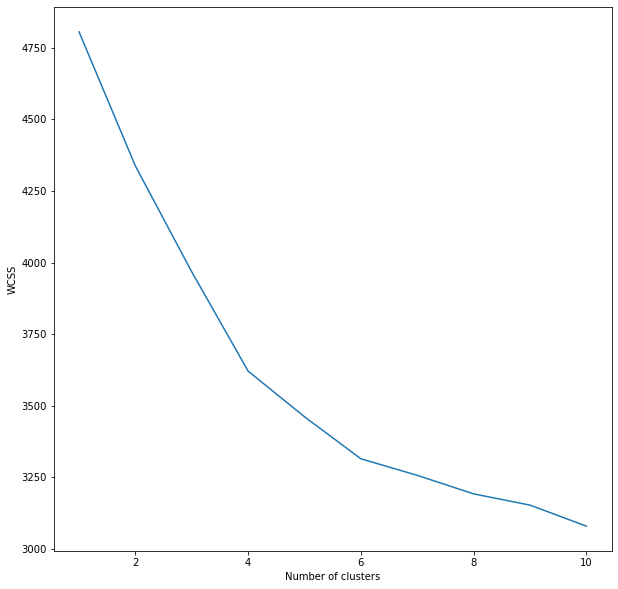

In [13]:
#elbow method to find optimal number of clusters for kmeans
wcss = []
for i in range(1,11):
   kmeans = KMeans(n_clusters = i, init = "k-means++")
   kmeans.fit(pca_result)
   wcss.append(kmeans.inertia_)
   print('Number of clusters:',i)
plt.figure(figsize=(10,10))
plt.plot(range(1,11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

silhouette_score of 2 clusters is: 0.1568734686830686
silhouette_score of 3 clusters is: 0.1876513243704869
silhouette_score of 4 clusters is: 0.23263237259396963
silhouette_score of 5 clusters is: 0.2605748213353883
silhouette_score of 6 clusters is: 0.230569633393748
silhouette_score of 7 clusters is: 0.23820838607799166
silhouette_score of 8 clusters is: 0.24709202654796378
silhouette_score of 9 clusters is: 0.2647892707832776
silhouette_score of 10 clusters is: 0.2307871477593539
silhouette_score of 11 clusters is: 0.26755556476617515


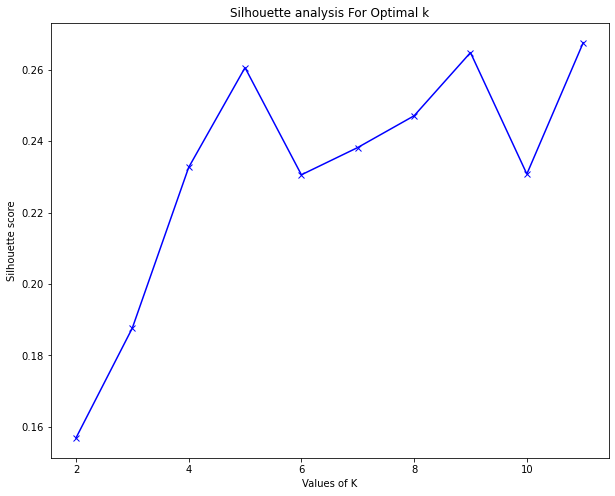

In [14]:
#silhouette score method to find optimal number of clusters for kmeans
range_n_clusters = [i for i in range(2,12)]
silhouette_avg = []
for num_clusters in range_n_clusters:
     # initialise kmeans
     kmeans = KMeans(n_clusters=num_clusters)
     kmeans.fit(pca_result)
     #cluster_labels= kmeans.labels_
     # silhouette score
     print(f'silhouette_score of {num_clusters} clusters is:',silhouette_score(pca_result, kmeans.labels_, metric='euclidean'))   
     silhouette_avg.append(silhouette_score(pca_result, kmeans.labels_, metric='euclidean'))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [15]:
#running kmeans n optimal number of clusters
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans = kmeans.fit(pca_result)
kmeans.labels_
# "predictions" for new data
predictions = kmeans.predict(pca_result)

In [16]:
tweets['clusters']=kmeans.labels_
tweets['clusters'].value_counts()

8    3200
9     753
2     505
5     479
4     419
1     324
7     285
0     121
6     102
3      82
Name: clusters, dtype: int64

In [17]:
#selecting only clusters containing relevant tweets
tweets=tweets[(tweets['clusters']==1)|(tweets['clusters']==2)|(tweets['clusters']==3)|(tweets['clusters']==4)|(tweets['clusters']==9)]

In [18]:
tweets.head()

,date,tweet_id,tweet,username,retweets,likes,id,tweet_cleaned,clusters
0,2022-04-16,1515284652889722880,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,1,royal society player rumble kong league lazy l...,2
6,2022-04-16,1515194035568361475,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,7,royal society player rumble kong league lazy l...,2
10,2022-04-15,1515103488518283278,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,11,royal society player rumble kong league lazy l...,2
14,2022-04-15,1515012912376602624,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,15,royal society player rumble kong league lazy l...,2
22,2022-04-15,1514922259210776584,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,23,royal society player rumble kong league lazy l...,2


In [19]:
tweets['likes'].describe()

count    2083.000000
mean        3.079693
std        26.804149
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max      1176.000000
Name: likes, dtype: float64

In [20]:
tweets['retweets'].describe()

count    2083.000000
mean        0.793087
std        18.403053
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       836.000000
Name: retweets, dtype: float64

In [21]:
#creating popular tweets and very popular tweets from likes and retweets
tweets['popular_tweet']=(tweets['retweets']>np.percentile(tweets['retweets'],75)) | (tweets['likes']>np.percentile(tweets['likes'],75))
tweets['very_popular_tweet']=(tweets['retweets']>np.percentile(tweets['retweets'],95)) | (tweets['likes']>np.percentile(tweets['likes'],95))

In [22]:
tweets.head()

,date,tweet_id,tweet,username,retweets,likes,id,tweet_cleaned,clusters,popular_tweet,very_popular_tweet
0,2022-04-16,1515284652889722880,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,1,royal society player rumble kong league lazy l...,2,False,False
6,2022-04-16,1515194035568361475,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,7,royal society player rumble kong league lazy l...,2,False,False
10,2022-04-15,1515103488518283278,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,11,royal society player rumble kong league lazy l...,2,False,False
14,2022-04-15,1515012912376602624,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,15,royal society player rumble kong league lazy l...,2,False,False
22,2022-04-15,1514922259210776584,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,23,royal society player rumble kong league lazy l...,2,False,False


In [23]:
tweets['popular_tweet'].value_counts()

False    1587
True      496
Name: popular_tweet, dtype: int64

In [24]:
tweets['very_popular_tweet'].value_counts()

False    1961
True      122
Name: very_popular_tweet, dtype: int64

In [25]:
tweets['word_count'] = tweets['tweet_cleaned'].apply(lambda x : len(x.split()))

In [26]:
#obtaining sentiments for the tweets
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment_polarity = blob.sentiment.polarity
    sentiment_subjectivity = blob.sentiment.subjectivity
    if sentiment_polarity > 0:
        sentiment_label = 'Positive'
    elif sentiment_polarity < 0:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    result = {'polarity':sentiment_polarity,
              'subjectivity':sentiment_subjectivity,
              'sentiment':sentiment_label}
    return result

In [27]:
tweets['sentiment_results'] = tweets['tweet_cleaned'].apply(get_sentiment)

In [28]:
len(tweets)

2083

In [29]:
sentiment=pd.json_normalize(tweets['sentiment_results'])

In [30]:
len(tweets),len(sentiment)

(2083, 2083)

In [31]:
tweets=tweets.reset_index()
sentiment=sentiment.reset_index()

In [32]:
tweets=(pd.concat([tweets,sentiment],axis=1))

In [33]:
tweets.tail()

,index,date,tweet_id,tweet,username,retweets,likes,id,tweet_cleaned,clusters,popular_tweet,very_popular_tweet,word_count,sentiment_results,index,polarity,subjectivity,sentiment
2078,5628,2021-10-19,1450516286719545350,The #1 Collection by Volume (last 10 mins):\np...,spr3adsh33t,0,2,5625,collection volume last min parallel parallelal...,4,False,False,19,"{'polarity': 0.09375, 'subjectivity': 0.329166...",2078,0.09375,0.329167,Positive
2079,5985,2021-08-27,1431289478530928641,Top 5 trending NFT collectibles on OpenSea ove...,JohnTodaro1,0,4,5982,top trending nft collectible opensea week cryp...,9,True,False,18,"{'polarity': -0.125, 'subjectivity': 0.575, 's...",2079,-0.12500,0.575000,Negative
2080,6000,2021-08-26,1430815649690005508,The #1 Collection by Volume (last 10 mins):\np...,spr3adsh33t,0,0,5997,collection volume last min parallel parallelal...,4,False,False,19,"{'polarity': 0.09375, 'subjectivity': 0.329166...",2080,0.09375,0.329167,Positive
2081,6001,2021-08-26,1430803023211683842,The #1 Collection by Volume (last 10 mins):\np...,spr3adsh33t,0,0,5998,collection volume last min parallel parallelal...,4,False,False,19,"{'polarity': 0.09375, 'subjectivity': 0.329166...",2081,0.09375,0.329167,Positive
2082,6030,2021-08-24,1429982308799553541,The #1 Collection by Volume (last 10 mins):\np...,spr3adsh33t,0,0,6029,collection volume last min parallel parallelal...,4,False,False,19,"{'polarity': 0.09375, 'subjectivity': 0.329166...",2082,0.09375,0.329167,Positive


In [34]:
tweets.isnull().sum()

index                 0
date                  0
tweet_id              0
tweet                 0
username              0
retweets              0
likes                 0
id                    0
tweet_cleaned         0
clusters              0
popular_tweet         0
very_popular_tweet    0
word_count            0
sentiment_results     0
index                 0
polarity              0
subjectivity          0
sentiment             0
dtype: int64

In [35]:
#obtaining how readable a tweet is
tweets['readability']=[flesch_reading_ease(i) for i in tweets['tweet_cleaned'].apply(str)]

In [36]:
tweets.head()

,index,date,tweet_id,tweet,username,retweets,likes,id,tweet_cleaned,clusters,popular_tweet,very_popular_tweet,word_count,sentiment_results,index,polarity,subjectivity,sentiment,readability
0,0,2022-04-16,1515284652889722880,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,1,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",0,-0.125,0.5,Negative,22.75
1,6,2022-04-16,1515194035568361475,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,7,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",1,-0.125,0.5,Negative,22.75
2,10,2022-04-15,1515103488518283278,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,11,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",2,-0.125,0.5,Negative,22.75
3,14,2022-04-15,1515012912376602624,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,15,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",3,-0.125,0.5,Negative,22.75
4,22,2022-04-15,1514922259210776584,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,23,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",4,-0.125,0.5,Negative,22.75


In [37]:
df = tweets.copy()

In [38]:
#obtaining datetime components
df['date']=pd.to_datetime(df['date'])
df['day']=df['date'].dt.day
df['week']=df['date'].dt.week
df['month']=df['date'].dt.month

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.


<AxesSubplot:>

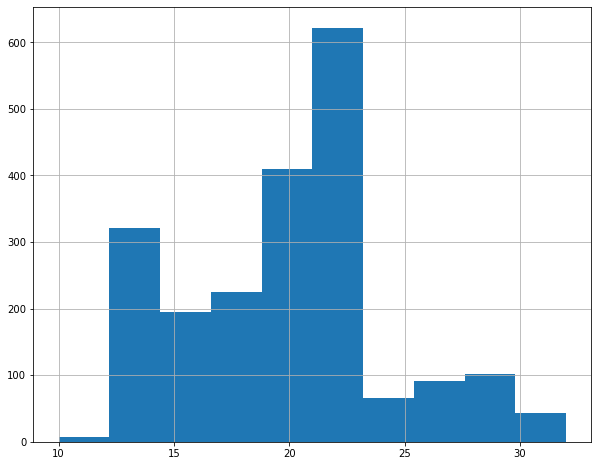

In [39]:
df['word_count'].hist()

#### Most tweets were around 22 words long, and majority of the tweets contained words fewer than 20

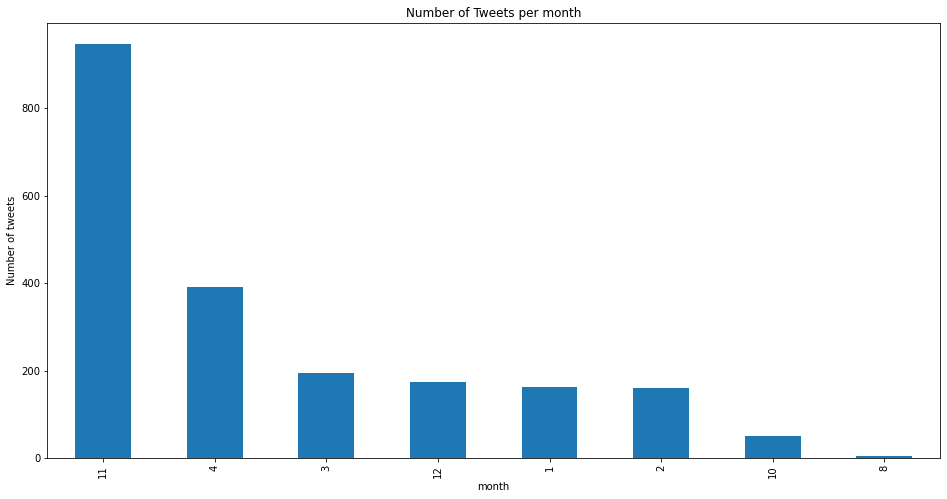

In [40]:
plt.figure(figsize=(16,8))
df['month'].value_counts().plot(kind='bar')
plt.title('Number of Tweets per month')
plt.xlabel('month')
plt.ylabel('Number of tweets');

#### November was the month with the highest number of tweets on parallel alpha, with august being the least per the data we have
#### Parallel Alpha reached its highest peak in november, thats why there is an overwhelming number of tweets in november than other months

In [41]:
parallel=pd.read_sql_query("SELECT * FROM parallel_alpha_trades",conn)
parallel.tail()

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


,chain,collectionaddress,collectionname,exchange,logindex,maker,price,quotecurrency,side,taker,thumbnailurl,timestamp,tokenid,tx,txindex,id
131357,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,153,0xe20f75642b97c11af651a81afcbbc6d7b4e32981,0.4200,ETH,buy,0xa8c045e857c1c4550119b612f22c3b27ece10340,https://storage.googleapis.com/parsec-nft-stor...,1625339709,87.0,0x2b9d31835cc90cf9206534c7da9dffd7edfbd4b900b4...,76.0,131358
131358,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,-1,0xc8301d3780efff7ee9fc579ab3b78aa5d6885a0a,0.4500,ETH,buy,0x41797b5e0398af475422f6f33f2dc81d9a24ae33,https://storage.googleapis.com/parsec-nft-stor...,1625323718,87.0,0x03d2923e72231726b99cda79073188cfb19195595530...,59.0,131359
131359,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,193,0xe20f75642b97c11af651a81afcbbc6d7b4e32981,0.3800,ETH,buy,0xf2327b04521589f505c7074c163805843a4bd6cd,https://storage.googleapis.com/parsec-nft-stor...,1625275386,87.0,0xd3168d526e49d9f361e0f8d5dec7e7d5b91733f72b0e...,116.0,131360
131360,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,198,0x52d7e31678d712ee8c15ca5af10babc257e5b61a,0.3500,ETH,buy,0x167539702b5501aadd9b0b85e53532fd57cc71a9,https://storage.googleapis.com/parsec-nft-stor...,1625220839,73.0,0x180169adcc282d403943b1a6c74a55c921547455adf4...,146.0,131361
131361,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,75,0x98c45d5ea9ccd8278fe43ba740e967a49cd19e6e,0.0099,ETH,buy,0x1c73c6174eb2fddc2e0a702e85cd3146c05aa122,https://storage.googleapis.com/parsec-nft-stor...,1625177755,10089.0,0x56d15482b8e9433db79c4fcfb0788e384cb38ec027aa...,40.0,131362


In [42]:
#obtain datetime from timestamp
from datetime import datetime
parallel['date']=parallel['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [43]:
parallel['date']=pd.to_datetime(parallel['date'])


In [45]:
df.head()

,index,date,tweet_id,tweet,username,retweets,likes,id,tweet_cleaned,clusters,popular_tweet,very_popular_tweet,word_count,sentiment_results,index,polarity,subjectivity,sentiment,readability,day,week,month
0,0,2022-04-16,1515284652889722880,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,1,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",0,-0.125,0.5,Negative,22.75,16,15,4
1,6,2022-04-16,1515194035568361475,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,7,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",1,-0.125,0.5,Negative,22.75,16,15,4
2,10,2022-04-15,1515103488518283278,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,11,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",2,-0.125,0.5,Negative,22.75,15,15,4
3,14,2022-04-15,1515012912376602624,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,15,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",3,-0.125,0.5,Negative,22.75,15,15,4
4,22,2022-04-15,1514922259210776584,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,23,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",4,-0.125,0.5,Negative,22.75,15,15,4


In [49]:
df['date'].min(), df['date'].max()

(Timestamp('2021-08-24 00:00:00'), Timestamp('2022-04-16 00:00:00'))

In [50]:
parallel['date'].min(), parallel['date'].max()

(Timestamp('2021-07-01 22:15:55'), Timestamp('2022-04-12 23:04:09'))

In [51]:
#extracting for only relevant dates
df=df[df['date']<='2022-04-12']
parallel=parallel[parallel['date']>'2021-08-24']

In [52]:
len(df)

1883

In [53]:
df.isnull().sum()

index                 0
date                  0
tweet_id              0
tweet                 0
username              0
retweets              0
likes                 0
id                    0
tweet_cleaned         0
clusters              0
popular_tweet         0
very_popular_tweet    0
word_count            0
sentiment_results     0
index                 0
polarity              0
subjectivity          0
sentiment             0
readability           0
day                   0
week                  0
month                 0
dtype: int64

In [54]:
#querying for only prices above 0.2 and under 2
parallel=parallel[(parallel['price']>0.2)&(parallel['price']<2)]

In [55]:
#aggregating financial data to weekly
parallel=parallel.groupby([pd.Grouper(key='date', freq='w-tue'),  'collectionname']).agg({
    'maker':['nunique'],
    'taker':['nunique'],
    'thumbnailurl':['nunique'],
    'tx':['nunique'],
    'price':['mean']})

In [56]:
df.head(1)

,index,date,tweet_id,tweet,username,retweets,likes,id,tweet_cleaned,clusters,popular_tweet,very_popular_tweet,word_count,sentiment_results,index,polarity,subjectivity,sentiment,readability,day,week,month
200,240,2022-04-12,1514016287831334916,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,240,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",200,-0.125,0.5,Negative,22.75,12,15,4


In [57]:
#aggregating twitter data to weekly
agg_df=df.groupby([pd.Grouper(key='date', freq='w-tue')]).agg({
    'word_count':['mean'],
    'popular_tweet':'first',
    'very_popular_tweet':'first',
    'readability':['mean'],
    'sentiment':'first'})

In [58]:
len(agg_df),len(parallel)

(34, 34)

In [59]:
def flatten_columns(df, prefix=''):
    columns = []
    for cs in df:
        if type(cs) is str:
            cs = re.sub('\W+','_', cs)
        elif type(cs) is not list and type(cs) is not tuple:
            print (cs)
            cs = str(cs)
        else:
            cs = re.sub("\W+", "", "".join([str(c) for c in cs]))
        cs = cs.lower()
        if prefix:
            cs = prefix + '' + cs
        cs = re.sub('\+$', '', cs)
        columns.append(cs)
    return columns

In [60]:
agg_df.columns=flatten_columns(agg_df)
parallel.columns=flatten_columns(parallel)

In [61]:
agg_df=agg_df.reset_index()
parallel=parallel.reset_index()

In [62]:
df.head()

,index,date,tweet_id,tweet,username,retweets,likes,id,tweet_cleaned,clusters,popular_tweet,very_popular_tweet,word_count,sentiment_results,index,polarity,subjectivity,sentiment,readability,day,week,month
200,240,2022-04-12,1514016287831334916,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,240,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",200,-0.125,0.5,Negative,22.75,12,15,4
201,243,2022-04-12,1513925715783299074,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,1,2,243,royal society player rumble kong league lazy l...,2,True,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",201,-0.125,0.5,Negative,22.75,12,15,4
202,244,2022-04-12,1513903051542773760,Parallel Alpha was just listed for 0.17 ETH. \...,nft_watcher_bot,0,3,244,parallel alpha listed eth http co ba bzrcpo nf...,1,True,False,14,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentim...",202,0.000,0.0,Neutral,48.81,12,15,4
203,245,2022-04-12,1513902025116901378,Parallel Alpha was just listed for 0.0014 ETH....,nft_watcher_bot,0,1,245,parallel alpha listed eth http co z ow l saw n...,1,False,False,16,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentim...",203,0.000,0.0,Neutral,55.24,12,15,4
204,246,2022-04-12,1513899787468292102,Parallel Alpha was just listed for 0.027 ETH. ...,nft_watcher_bot,0,0,246,parallel alpha listed eth http co kfmx cp nft ...,1,False,False,14,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentim...",204,0.000,0.0,Neutral,57.27,12,15,4


In [63]:
parallel.head()

,date,collectionname,makernunique,takernunique,thumbnailurlnunique,txnunique,pricemean
0,2021-08-24,Parallel Alpha,821,643,77,1515,0.582914
1,2021-08-31,Parallel Alpha,963,1031,87,2898,0.529011
2,2021-09-07,Parallel Alpha,230,252,60,474,0.470613
3,2021-09-14,Parallel Alpha,144,123,51,238,0.487991
4,2021-09-21,Parallel Alpha,105,99,50,168,0.442037


In [64]:
parallel=parallel.rename(columns={'pricemean':'median_price',
                  'makernunique':'num_of_sellers','takernunique':'number_of_buyers','thumbnailurlnunique':'volume_of_assets_traded',
                  'txnunique':'number_of_transcations_index'})

In [65]:
len(parallel),len(agg_df)

(34, 34)

In [66]:
parallel.head(2)

,date,collectionname,num_of_sellers,number_of_buyers,volume_of_assets_traded,number_of_transcations_index,median_price
0,2021-08-24,Parallel Alpha,821,643,77,1515,0.582914
1,2021-08-31,Parallel Alpha,963,1031,87,2898,0.529011


<AxesSubplot:>

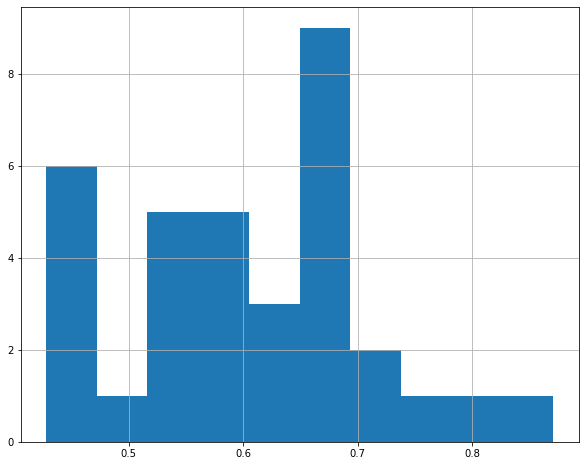

In [67]:
parallel['median_price'].hist()

In [68]:
#color_list = [
#    "blue",
#    "orange",
#    "green",
#    "red",
#    "purple",
#    "brown",
#    "pink",
#    "gray",
#    "olive",
#    "cyan",
#]
#
#
#def Visualize(data):
#    features= list(df.select_dtypes(include=[np.number]).columns.values)
#    feature_size=len(features)
#    fig, axes = plt.subplots(
#        nrows=int(np.ceil(feature_size/2)), ncols=2, figsize=(14, feature_size*2), dpi=80, facecolor="w", edgecolor="k"
#    )
#    for i in range(feature_size):
#        key = features[i]
#        c = color_list[i % (len(color_list))]
#        t_data = data[key]
#        t_data.head()
#        ax = t_data.plot(
#            ax=axes[i // 2, i % 2],
#            color=c,
#            title="{}".format(key),
#            rot=25,
#        )
#        ax.legend([key])
#    plt.tight_layout()
#
#
#Visualize(parallel)

In [69]:
parallel.head()

,date,collectionname,num_of_sellers,number_of_buyers,volume_of_assets_traded,number_of_transcations_index,median_price
0,2021-08-24,Parallel Alpha,821,643,77,1515,0.582914
1,2021-08-31,Parallel Alpha,963,1031,87,2898,0.529011
2,2021-09-07,Parallel Alpha,230,252,60,474,0.470613
3,2021-09-14,Parallel Alpha,144,123,51,238,0.487991
4,2021-09-21,Parallel Alpha,105,99,50,168,0.442037


In [70]:
agg_df.head(1)

,date,word_countmean,popular_tweetfirst,very_popular_tweetfirst,readabilitymean,sentimentfirst
0,2021-08-24,19.0,0.0,0.0,52.19,Positive


In [71]:
agg_df['date'].min(),agg_df['date'].max()


(Timestamp('2021-08-24 00:00:00'), Timestamp('2022-04-12 00:00:00'))

In [72]:
parallel['date'].min(),parallel['date'].max()

(Timestamp('2021-08-24 00:00:00'), Timestamp('2022-04-12 00:00:00'))

In [73]:
agg_df=agg_df.reset_index()
parallel=parallel.reset_index()

In [74]:
agg_df=agg_df.merge(parallel, on='date')

In [75]:
agg_df.tail()

,index_x,date,word_countmean,popular_tweetfirst,very_popular_tweetfirst,readabilitymean,sentimentfirst,index_y,collectionname,num_of_sellers,number_of_buyers,volume_of_assets_traded,number_of_transcations_index,median_price
29,29,2022-03-15,24.066667,0.0,0.0,35.204000,Positive,29,Parallel Alpha,201,118,43,213,0.663570
30,30,2022-03-22,24.200000,1.0,0.0,32.361600,Negative,30,Parallel Alpha,95,70,33,120,0.585938
31,31,2022-03-29,23.307692,1.0,0.0,25.040769,Negative,31,Parallel Alpha,53,33,28,59,0.650800
32,32,2022-04-05,22.531250,1.0,0.0,25.605313,Negative,32,Parallel Alpha,34,27,20,36,0.555254
33,33,2022-04-12,15.343373,0.0,0.0,45.201325,Negative,33,Parallel Alpha,42,33,26,46,0.565667


In [76]:
agg_df.isnull().sum()

index_x                         0
date                            0
word_countmean                  6
popular_tweetfirst              6
very_popular_tweetfirst         6
readabilitymean                 6
sentimentfirst                  6
index_y                         0
collectionname                  0
num_of_sellers                  0
number_of_buyers                0
volume_of_assets_traded         0
number_of_transcations_index    0
median_price                    0
dtype: int64

In [77]:
agg_df=agg_df.dropna()

In [78]:
corr_matrix = agg_df.corr()
(corr_matrix["median_price"].sort_values(ascending=False))[:20]

median_price                    1.000000
very_popular_tweetfirst         0.369006
word_countmean                  0.263902
index_x                         0.188573
index_y                         0.188573
popular_tweetfirst             -0.112178
num_of_sellers                 -0.159648
number_of_transcations_index   -0.214719
readabilitymean                -0.219277
number_of_buyers               -0.222576
volume_of_assets_traded        -0.240515
Name: median_price, dtype: float64

In [79]:
df.head()

,index,date,tweet_id,tweet,username,retweets,likes,id,tweet_cleaned,clusters,popular_tweet,very_popular_tweet,word_count,sentiment_results,index,polarity,subjectivity,sentiment,readability,day,week,month
200,240,2022-04-12,1514016287831334916,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,240,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",200,-0.125,0.5,Negative,22.75,12,15,4
201,243,2022-04-12,1513925715783299074,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,1,2,243,royal society player rumble kong league lazy l...,2,True,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",201,-0.125,0.5,Negative,22.75,12,15,4
202,244,2022-04-12,1513903051542773760,Parallel Alpha was just listed for 0.17 ETH. \...,nft_watcher_bot,0,3,244,parallel alpha listed eth http co ba bzrcpo nf...,1,True,False,14,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentim...",202,0.000,0.0,Neutral,48.81,12,15,4
203,245,2022-04-12,1513902025116901378,Parallel Alpha was just listed for 0.0014 ETH....,nft_watcher_bot,0,1,245,parallel alpha listed eth http co z ow l saw n...,1,False,False,16,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentim...",203,0.000,0.0,Neutral,55.24,12,15,4
204,246,2022-04-12,1513899787468292102,Parallel Alpha was just listed for 0.027 ETH. ...,nft_watcher_bot,0,0,246,parallel alpha listed eth http co kfmx cp nft ...,1,False,False,14,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentim...",204,0.000,0.0,Neutral,57.27,12,15,4


<AxesSubplot:>

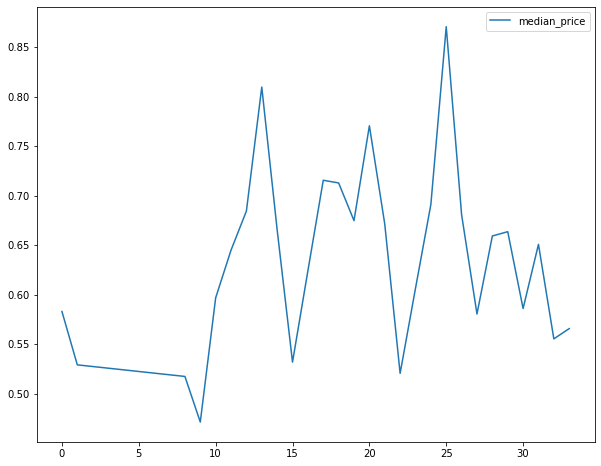

In [80]:
agg_df[['median_price']].plot(kind='line')

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

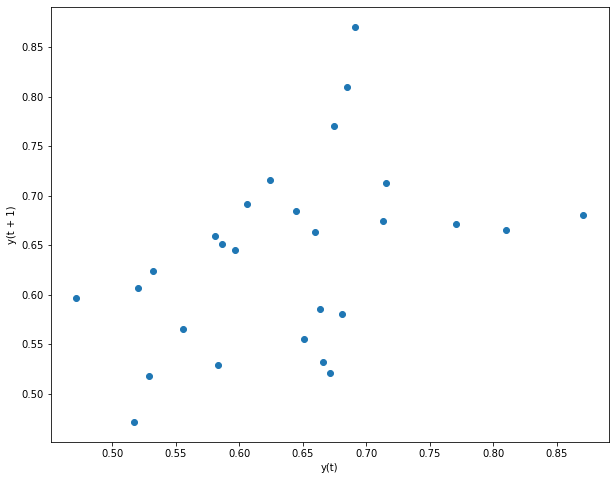

In [81]:
pd.plotting.lag_plot(agg_df['median_price'],lag=1)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 4)'>

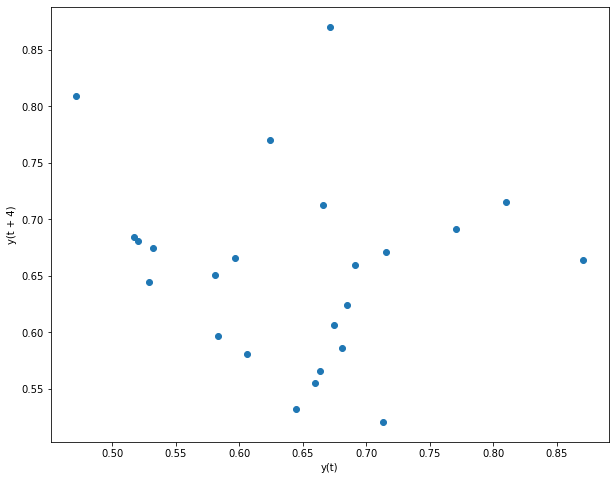

In [82]:
pd.plotting.lag_plot(agg_df['median_price'],lag=4)

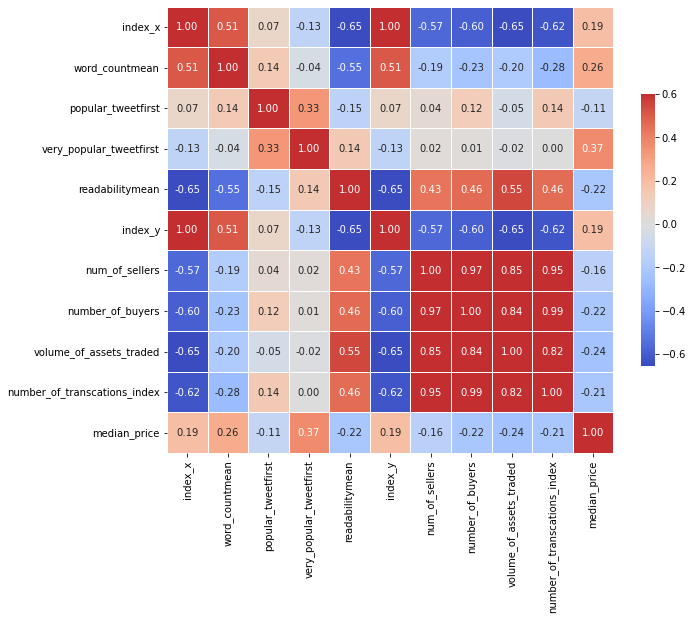

In [83]:
g = sns.heatmap(corr_matrix,  vmax=.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.figure.set_size_inches(10,10)
    
plt.show()

In [84]:
result = adfuller(agg_df['median_price'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critial Values: {result[4]}')

if result[1] > 0.05 :
  print('Series is not Stationary')
else:
  print('Series is Stationary')

Test Statistics: -3.777861348377627
p-value: 0.0031421199878699764
Critial Values: {'1%': -3.7112123008648155, '5%': -2.981246804733728, '10%': -2.6300945562130176}
Series is Stationary


In [85]:
#split data into train and test sets
split_date ='2022-03-01'
df_train = agg_df.loc[agg_df.date <= split_date].copy()
df_test = agg_df.loc[agg_df.date > split_date].copy()

In [86]:
len(df_train), len(df_test)

(22, 6)

In [87]:
agg_df.head()

,index_x,date,word_countmean,popular_tweetfirst,very_popular_tweetfirst,readabilitymean,sentimentfirst,index_y,collectionname,num_of_sellers,number_of_buyers,volume_of_assets_traded,number_of_transcations_index,median_price
0,0,2021-08-24,19.000000,0.0,0.0,52.190000,Positive,0,Parallel Alpha,821,643,77,1515,0.582914
1,1,2021-08-31,18.666667,1.0,0.0,52.530000,Negative,1,Parallel Alpha,963,1031,87,2898,0.529011
8,8,2021-10-19,19.000000,0.0,0.0,52.190000,Positive,8,Parallel Alpha,82,62,49,124,0.517299
9,9,2021-10-26,15.666667,0.0,0.0,48.525000,Positive,9,Parallel Alpha,69,69,45,117,0.471237
10,10,2021-11-02,19.344681,0.0,0.0,44.748979,Positive,10,Parallel Alpha,827,737,97,1801,0.596750


In [88]:
sent=pd.get_dummies(agg_df['sentimentfirst'])
agg_df=agg_df.drop(columns=['sentimentfirst'])
agg_df=pd.concat([agg_df, sent],axis=1)
agg_df['popular_tweetfirst']=agg_df['popular_tweetfirst'].astype('object')
agg_df['very_popular_tweetfirst']=agg_df['very_popular_tweetfirst'].astype('object')
pop = pd.get_dummies(agg_df[['popular_tweetfirst','very_popular_tweetfirst']])
agg_df=agg_df.drop(columns=['popular_tweetfirst','very_popular_tweetfirst'])
agg_df=pd.concat([agg_df, pop],axis=1)

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


In [89]:
agg_df.head()

,index_x,date,word_countmean,readabilitymean,index_y,collectionname,num_of_sellers,number_of_buyers,volume_of_assets_traded,number_of_transcations_index,median_price,Negative,Neutral,Positive,popular_tweetfirst_0.0,popular_tweetfirst_1.0,very_popular_tweetfirst_0.0,very_popular_tweetfirst_1.0
0,0,2021-08-24,19.000000,52.190000,0,Parallel Alpha,821,643,77,1515,0.582914,0,0,1,1,0,1,0
1,1,2021-08-31,18.666667,52.530000,1,Parallel Alpha,963,1031,87,2898,0.529011,1,0,0,0,1,1,0
8,8,2021-10-19,19.000000,52.190000,8,Parallel Alpha,82,62,49,124,0.517299,0,0,1,1,0,1,0
9,9,2021-10-26,15.666667,48.525000,9,Parallel Alpha,69,69,45,117,0.471237,0,0,1,1,0,1,0
10,10,2021-11-02,19.344681,44.748979,10,Parallel Alpha,827,737,97,1801,0.596750,0,0,1,1,0,1,0


In [90]:
agg_df.tail()

,index_x,date,word_countmean,readabilitymean,index_y,collectionname,num_of_sellers,number_of_buyers,volume_of_assets_traded,number_of_transcations_index,median_price,Negative,Neutral,Positive,popular_tweetfirst_0.0,popular_tweetfirst_1.0,very_popular_tweetfirst_0.0,very_popular_tweetfirst_1.0
29,29,2022-03-15,24.066667,35.204000,29,Parallel Alpha,201,118,43,213,0.663570,0,0,1,1,0,1,0
30,30,2022-03-22,24.200000,32.361600,30,Parallel Alpha,95,70,33,120,0.585938,1,0,0,0,1,1,0
31,31,2022-03-29,23.307692,25.040769,31,Parallel Alpha,53,33,28,59,0.650800,1,0,0,0,1,1,0
32,32,2022-04-05,22.531250,25.605313,32,Parallel Alpha,34,27,20,36,0.555254,1,0,0,0,1,1,0
33,33,2022-04-12,15.343373,45.201325,33,Parallel Alpha,42,33,26,46,0.565667,1,0,0,1,0,1,0


In [91]:
agg_df.to_csv('final_data.csv')

In [92]:
X_train = agg_df[agg_df['date'] <= '2022-03-01']
X_valid = agg_df[agg_df['date'] >= '2022-03-01']

print('X_train Shape', X_train.shape)
print('X_Valid Shape', X_valid.shape)

X_valid['date'].unique()

X_train Shape (22, 18)
X_Valid Shape (7, 18)


array(['2022-03-01T00:00:00.000000000', '2022-03-08T00:00:00.000000000',
       '2022-03-15T00:00:00.000000000', '2022-03-22T00:00:00.000000000',
       '2022-03-29T00:00:00.000000000', '2022-04-05T00:00:00.000000000',
       '2022-04-12T00:00:00.000000000'], dtype='datetime64[ns]')

In [93]:
# filtering the train data
#au = X_train[X_train['country'] == 'Australia']
au2 = X_train[['date', 'median_price']]

#filtering the valid data
#au_v = X_valid[X_valid['country'] == 'Australia']
au_v2 = X_valid[['date', 'median_price']]

# set the date into index
au2.set_index('date', inplace=True)
au_v2.set_index('date', inplace=True)

# Setting the Index for 6 years
index_7_years = pd.date_range(au2.index[-1], freq='d', periods = len(X_valid)) 

index_7_years

DatetimeIndex(['2022-03-01', '2022-03-02', '2022-03-03', '2022-03-04',
               '2022-03-05', '2022-03-06', '2022-03-07'],
              dtype='datetime64[ns]', freq='D')

In [94]:
agg_df['median_price'].describe()

count    28.000000
mean      0.636883
std       0.091801
min       0.471237
25%       0.576722
50%       0.647856
75%       0.681607
max       0.870716
Name: median_price, dtype: float64

In [95]:
np.percentile(agg_df['median_price'],65)

0.6687344935754691

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.



Initial log joint probability = -190.54
Iteration  1. Log joint probability =   -3.10313. Improved by 187.437.
Iteration  2. Log joint probability =   -3.04125. Improved by 0.061884.
Iteration  3. Log joint probability =   -3.03463. Improved by 0.00661565.
Iteration  4. Log joint probability =   -3.03113. Improved by 0.00350559.
Iteration  5. Log joint probability =   -3.00229. Improved by 0.0288358.
Iteration  6. Log joint probability =   -2.97647. Improved by 0.025823.
Iteration  7. Log joint probability =   -2.90186. Improved by 0.0746134.
Iteration  8. Log joint probability =   -2.80595. Improved by 0.0959013.
Iteration  9. Log joint probability =   -2.78202. Improved by 0.0239296.
Iteration 10. Log joint probability =   -2.73482. Improved by 0.0472001.
Iteration 11. Log joint probability =   -2.69996. Improved by 0.0348659.
Iteration 12. Log joint probability =    -2.6189. Improved by 0.0810547.
Iteration 13. Log joint probability =    -2.3779. Improved by 0.241004.
Iteration 14.

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


The MSE of prophet is: 0.28702551764164597


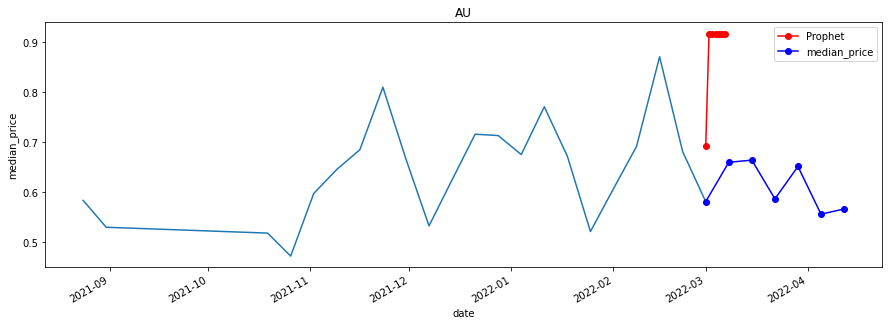

In [96]:
# prepare expected column names
au3 = X_train.copy()
au3 = au3[['date', 'median_price']]
au3.columns = ['ds', 'y']
au3['ds']= pd.to_datetime(au3['ds'])
au3['cap']=0.9
au3['floor']=0.67
# define the model
model = Prophet(growth='logistic',weekly_seasonality=True)
# fit the model
model.fit(au3)

# define the period for which we want a prediction
df_index_7_years = pd.DataFrame(index_7_years)
df_index_7_years.columns = ['ds']
df_index_7_years['ds']= pd.to_datetime(df_index_7_years['ds'])
df_index_7_years['cap']=0.9
df_index_7_years['floor']=0.67

# use the model to make a forecast
fcast3 = model.predict(df_index_7_years)
fcast3 = pd.Series(fcast3['yhat'].values, index=index_7_years)
fcast3 = fcast3.rename("Prophet")

# Ploting the predictions
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='date', y='median_price', data = X_train)
chart.set_title('AU')
fcast3.plot(ax=ax, color='red', marker="o", legend=True)
au_v2.plot(ax=ax, color='blue', marker="o", legend=True)

# Printing the AI
print('The MSE of prophet is:', mean_squared_error(X_valid['median_price'].values, fcast3.values, squared=False))

In [97]:
model.predict(df_index_7_years)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-03-01,0.883610,0.9,0.67,0.576515,0.798192,0.883610,0.883610,-0.192655,-0.192655,-0.192655,-0.192655,-0.192655,-0.192655,0.0,0.0,0.0,0.690955
1,2022-03-02,0.883892,0.9,0.67,0.800616,1.015016,0.883892,0.883892,0.032109,0.032109,0.032109,0.032109,0.032109,0.032109,0.0,0.0,0.0,0.916001
2,2022-03-03,0.884170,0.9,0.67,0.807188,1.024672,0.884170,0.884170,0.032109,0.032109,0.032109,0.032109,0.032109,0.032109,0.0,0.0,0.0,0.916279
3,2022-03-04,0.884443,0.9,0.67,0.813275,1.029364,0.884443,0.884443,0.032109,0.032109,0.032109,0.032109,0.032109,0.032109,0.0,0.0,0.0,0.916552
4,2022-03-05,0.884711,0.9,0.67,0.817165,1.026275,0.884711,0.884711,0.032109,0.032109,0.032109,0.032109,0.032109,0.032109,0.0,0.0,0.0,0.916820
5,2022-03-06,0.884976,0.9,0.67,0.802191,1.024537,0.884976,0.884976,0.032109,0.032109,0.032109,0.032109,0.032109,0.032109,0.0,0.0,0.0,0.917085
6,2022-03-07,0.885236,0.9,0.67,0.808938,1.033717,0.885236,0.885236,0.032109,0.032109,0.032109,0.032109,0.032109,0.032109,0.0,0.0,0.0,0.917345


In [98]:
arima=agg_df[['date','median_price']]

In [99]:
arima=arima.set_index('date')

In [100]:
from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm


<AxesSubplot:xlabel='date'>

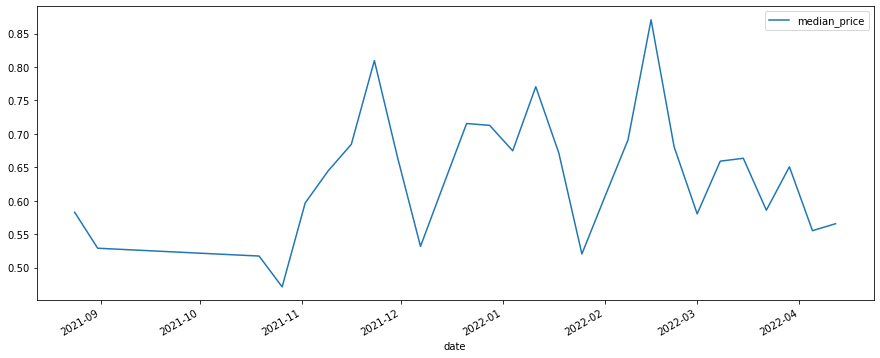

In [101]:
arima.plot(figsize=(15, 6))

In [104]:
import itertools

In [105]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [106]:
#Hyperparameter tuning
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        model_arima = sm.tsa.statespace.SARIMAX(arima,order=param,
                                               seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        model_arima_fit = model_arima.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, model_arima_fit.aic))
    

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.45963D-01    |proj g|=  9.90128D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      6      1     0     0   2.576D-05   9.460D-01
  F =  0.94595199558792575     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:54.97331175292384
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for


At iterate   10    f= -4.38261D-01    |proj g|=  9.88078D-02

At iterate   15    f= -4.38315D-01    |proj g|=  1.65030D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     26      1     0     0   1.650D-04  -4.383D-01
  F = -0.43831501268959944     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-20.54564071061757
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48763D-02    |proj g|=  2.07565D+00

At iterate   

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will


At iterate   10    f= -7.94232D-02    |proj g|=  2.03592D+00

At iterate   15    f= -1.01596D-01    |proj g|=  5.19136D-01

At iterate   20    f= -1.63203D-01    |proj g|=  3.58093D+00

At iterate   25    f= -2.00313D-01    |proj g|=  7.28551D-02
  ys=-1.077E-05  -gs= 1.287E-05 BFGS update SKIPPED

At iterate   30    f= -2.00450D-01    |proj g|=  1.21806D-02

At iterate   35    f= -2.00450D-01    |proj g|=  1.44493D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37    103      2     1     0   2.527D-03  -2.005D-01
  F = -0.20045040440664996     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be i

  ys=-8.445E-12  -gs= 3.599E-07 BFGS update SKIPPED
  ys=-4.086E+00  -gs= 3.764E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15    171      4     3     0   5.196D+04  -2.728D-01
  F = -0.27284748903853823     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 0, 2)x(0, 1, 1, 12)12 - AIC:-7.279459386158139
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15503D-01    |proj g|=  8.42750D-01

At iterate    5    f= -5.07190D-0

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.



At iterate   20    f= -3.18951D-01    |proj g|=  3.64448D+00

At iterate   25    f= -3.26375D-01    |proj g|=  1.68677D-01

At iterate   30    f= -3.26392D-01    |proj g|=  4.76077D-02

At iterate   35    f= -3.28636D-01    |proj g|=  2.06720D-01

At iterate   40    f= -3.28926D-01    |proj g|=  2.55916D-01

At iterate   45    f= -3.29587D-01    |proj g|=  3.17107D-02

At iterate   50    f= -3.29597D-01    |proj g|=  9.35124D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     84      1     0     0   9.351D-03  -3.296D-01
  F = -0.32959686075138561     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. f


At iterate   15    f= -2.05276D-01    |proj g|=  4.21786D+02
  ys=-2.930E-06  -gs= 1.581E-06 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17    136      2     4     0   4.454D+02  -2.054D-01
  F = -0.20544640882973625     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 2)x(1, 1, 1, 12)12 - AIC:-1.5049988944652295
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.87535D+01    |proj g|=  3.96509D+02

At iterate    5    f= 

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency inf


At iterate    5    f=  7.22674D-02    |proj g|=  1.43046D+00

At iterate   10    f= -4.87675D-01    |proj g|=  6.83959D-01

At iterate   15    f= -5.16044D-01    |proj g|=  3.40840D-02

At iterate   20    f= -5.16682D-01    |proj g|=  8.44915D-03

At iterate   25    f= -5.16743D-01    |proj g|=  3.17717D-02

At iterate   30    f= -5.16758D-01    |proj g|=  2.13666D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     45      1     0     0   2.137D-04  -5.168D-01
  F = -0.51675836734964797     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 3)x(1, 0, 0, 12)12 - AIC:-18.9384685715

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so wi


At iterate   50    f= -3.55354D-01    |proj g|=  1.25799D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     69      1     0     0   1.258D-01  -3.554D-01
  F = -0.35535432082779028     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 0, 3)x(1, 1, 0, 12)12 - AIC:-9.899841966356256
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number o

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Prev


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1     21      1     0     0         NaN  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 0, 4)x(1, 1, 1, 12)12 - AIC:14.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.28357D-01    |proj g|=  6.25655D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauc

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27    145      3     1     0   2.758D-01  -2.310D-01
  F = -0.23104084188291327     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-6.938287145443143
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.91591D-01    |proj g|=  1.45413D-01

At iterate    5    f= -7.97157D-01    |proj g|=  1.26513D+00

At iterate   10    f= -8.12730D-01    |proj g|=  5.71115D-03

           * 

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f= -1.32233D-01    |proj g|=  4.58053D-01

At iterate   15    f= -1.36494D-01    |proj g|=  1.12112D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     29      1     0     0   1.419D-04  -1.365D-01
  F = -0.13650513752221480     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-1.6442877012440285
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.15995D-02    |proj g|=  1.64133D+00

At iterate  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will b

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:-4.751773462211862
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.90533D-01    |proj g|=  1.67434D+00

At iterate    5    f= -8.99470D-01    |proj g|=  3.59648D-02

At iterate   10    f= -8.99653D-01    |proj g|=  1.18791D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   1.188D-05  -8.997D-01
  F = -0.89965348423528702     

CONVERGENCE: R


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, b


At iterate   25    f= -1.62131D-01    |proj g|=  2.96959D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     56      1     1     0   2.970D-04  -1.621D-01
  F = -0.16213110743890566     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(1, 1, 0, 12)12 - AIC:-1.0793420165787175
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number 

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency informa


At iterate   10    f= -3.43311D-01    |proj g|=  6.15954D-03

At iterate   15    f= -3.43436D-01    |proj g|=  1.09190D-01

At iterate   20    f= -3.45317D-01    |proj g|=  2.72557D-01

At iterate   25    f= -3.46611D-01    |proj g|=  7.57119D-03

At iterate   30    f= -3.47960D-01    |proj g|=  8.94113D-02

At iterate   35    f= -3.49366D-01    |proj g|=  3.13773D-02

At iterate   40    f= -3.49436D-01    |proj g|=  3.29155D-02

At iterate   45    f= -3.49546D-01    |proj g|=  6.99921D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     59      1     0     0   6.340D-04  -3.495D-01
  F = -0.349546615776

Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate 


At iterate   25    f= -4.34429D-01    |proj g|=  5.76790D-02

At iterate   30    f= -4.59930D-01    |proj g|=  2.77729D-02

At iterate   35    f= -4.65643D-01    |proj g|=  2.98972D-02

At iterate   40    f= -4.72897D-01    |proj g|=  6.24241D-01

At iterate   45    f= -4.85598D-01    |proj g|=  6.12963D-01

At iterate   50    f= -4.86814D-01    |proj g|=  1.17397D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   1.174D+00  -4.868D-01
  F = -0.48681356329685016     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 1, 4)x(1, 0, 1, 12)12 - AIC:-13.2615595446


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     35      1     0     0   8.444D-05  -2.405D-01
  F = -0.24049920765124111     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 0)x(1, 0, 1, 12)12 - AIC:-7.467955628469502
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.34341D-02    |proj g|=  4.04973D-03

At iterate    5    f= -8.34341D-02    |proj g|=  3.70160D-03

           * * *

Tit   = total number of iterations
Tnf   = total number o


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be i

ARIMA(0, 2, 1)x(0, 1, 1, 12)12 - AIC:6.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.51397D-01    |proj g|=  6.89415D-01

At iterate    5    f= -3.84676D-01    |proj g|=  2.11311D+00

At iterate   10    f= -4.00842D-01    |proj g|=  6.23678D-03

At iterate   15    f= -4.00888D-01    |proj g|=  2.03454D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     20      1     0     0   4.059D-05  -4.009D-01
  F = -0.40088789553989190     

CONVERGENCE: REL_REDUCTION_O

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for


At iterate    5    f= -2.85743D-01    |proj g|=  3.70453D+00

At iterate   10    f= -3.57338D-01    |proj g|=  2.04975D-01

At iterate   15    f= -4.04734D-01    |proj g|=  1.46386D+00

At iterate   20    f= -4.33326D-01    |proj g|=  1.83725D-01

At iterate   25    f= -4.52193D-01    |proj g|=  3.64196D-02

At iterate   30    f= -4.54121D-01    |proj g|=  1.94045D-01

At iterate   35    f= -4.54758D-01    |proj g|=  9.60505D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     50      1     0     0   3.407D-04  -4.548D-01
  F = -0.45475843194620869     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has 


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     49    159      3     0     0   6.857D-03  -9.151D-02
  F =  -9.1513031419707222E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(1, 1, 0, 12)12 - AIC:2.8752702404963957
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated


At iterate   20    f= -4.72821D-01    |proj g|=  4.86988D-03

At iterate   25    f= -4.72859D-01    |proj g|=  7.80181D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     36      1     0     0   1.488D-04  -4.729D-01
  F = -0.47285969958661112     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 3)x(1, 0, 0, 12)12 - AIC:-16.480143176850223
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.53865D-01    |proj g|=  2.52725D-01

At iterate  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will


At iterate   35    f= -8.36815D-02    |proj g|=  3.87215D-03
  ys=-3.404E-18  -gs= 1.624E-17 BFGS update SKIPPED
  ys=-4.243E-18  -gs= 1.776E-16 BFGS update SKIPPED
  ys=-2.377E-17  -gs= 5.822E-16 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39    170      4     3     0   5.072D-03  -8.368D-02
  F =  -8.3681504674683466E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 2, 3)x(1, 1, 0, 12)12 - AIC:5.313835738217726
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exact

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is uncon


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     21      1     0     0         NaN  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 2, 4)x(0, 1, 1, 12)12 - AIC:12.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.92708D-01    |proj g|=  2.55060D+00

At iterate    5    f= -4.35120D-01    |proj g|=  3.38228D-01

At iterate   10    f= -4.69123D-01    |proj g|=  9.72297D-01

At iterate   15    f= -4.71


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     21      1     0     0         NaN         NaN
  F =                       NaN

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 2, 4)x(1, 1, 0, 12)12 - AIC:nan
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauch

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     93      3     2     0   3.084D+03  -2.869D-01
  F = -0.28691145604920176     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 3, 0)x(1, 1, 0, 12)12 - AIC:-12.067041538755298
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explo


 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provide


At iterate    5    f= -2.92811D-01    |proj g|=  2.68280D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     72      2     1     0   2.683D+03  -2.928D-01
  F = -0.29281126964747423     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 3, 1)x(1, 1, 0, 12)12 - AIC:-10.397431100258558
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number 

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is uncon


At iterate   15    f= -2.13617D-01    |proj g|=  4.75319D-01

At iterate   20    f= -2.15153D-01    |proj g|=  7.75822D-03

At iterate   25    f= -2.15677D-01    |proj g|=  7.16760D-02

At iterate   30    f= -2.15791D-01    |proj g|=  4.37187D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     38      1     0     0   4.361D-04  -2.158D-01
  F = -0.21579050339939077     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 3, 3)x(0, 0, 1, 12)12 - AIC:-2.084268190365883
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been pr


At iterate   45    f= -3.38450D-01    |proj g|=  2.28324D-03

At iterate   50    f= -3.38450D-01    |proj g|=  2.27841D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     69      1     0     0   2.278D-03  -3.385D-01
  F = -0.33845043783715539     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 3, 3)x(1, 0, 1, 12)12 - AIC:-6.9532245188807025
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.43516D-02    |proj g|=  4.84239D-01

At iterate  

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate s

ARIMA(0, 3, 4)x(0, 0, 0, 12)12 - AIC:-23.018554168702934
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.22640D-02    |proj g|=  8.86660D-01

At iterate    5    f= -7.78889D-02    |proj g|=  2.51518D-01

At iterate   10    f= -1.03139D-01    |proj g|=  2.28584D-01

At iterate   15    f= -1.21271D-01    |proj g|=  1.91696D-01

At iterate   20    f= -1.27400D-01    |proj g|=  2.47607D-01

At iterate   25    f= -1.44365D-01    |proj g|=  2.41593D-02

At iterate   30    f= -1.44692D-01    |proj g|=  9.64108D-02

At iterate   35    f= -1.49025D-01    |proj g|=  1.09131D-01

At iterate   40    f= -1.49628D-01    |proj g|=  1.88406D-03

At iterate   45    f= -1.49638D-01    |proj g|=  5.63234D-03

At iterate   50    f= -1.49710D-01    |proj g|=  2.97172D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluat

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parame


At iterate   45    f= -2.89524D-01    |proj g|=  2.85313D-03

At iterate   50    f= -2.89525D-01    |proj g|=  1.64906D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.649D-04  -2.895D-01
  F = -0.28952527567425207     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 3, 4)x(1, 0, 0, 12)12 - AIC:-4.2134154377581154
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.22640D-02    |proj g|=  8.86660D-01

At iterate  

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.15622D+00    |proj g|=  6.94901D-01
  ys=-4.660E-14  -gs= 7.021E-14 BFGS update SKIPPED
  ys=-8.473E-14  -gs= 1.943E-13 BFGS update SKIPPED

At iterate   10    f=  8.26096D-01    |proj g|=  4.59864D+03

At iterate   15    f=  8.09704D-01    |proj g|=  4.14097D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17    206      4     2     0   3.187D-01   8.097D-01
  F =  0.80970327384613217     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 3, 4)x(1, 1, 0, 12)12 - AIC:57.3433833353834
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 4, 0)x(0, 1, 1, 12)12 - AIC:4.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date ind


At iterate   15    f= -9.53420D-02    |proj g|=  1.52810D-01

At iterate   20    f= -9.65077D-02    |proj g|=  9.88683D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   5.275D-04  -9.651D-02
  F =  -9.6507669582962891E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 4, 2)x(0, 0, 1, 12)12 - AIC:2.595570503354078
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.77581D-02    |proj g|=  5.33501D-01

At iterate    

 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has


At iterate   20    f= -9.01217D-02    |proj g|=  2.55387D-01

At iterate   25    f= -9.04543D-02    |proj g|=  3.59123D-02

At iterate   30    f= -9.55735D-02    |proj g|=  3.45557D-01

At iterate   35    f= -9.64082D-02    |proj g|=  4.03121D-02
ARIMA(0, 4, 3)x(0, 0, 1, 12)12 - AIC:4.5999717218306735
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     52      1     0     0   1.280D-03  -9.643D-02
  F =  -9.6429076395880831E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate p


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     53      1     0     0   1.490D-03  -1.553D-01
  F = -0.15531151942606730     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 4, 3)x(1, 0, 1, 12)12 - AIC:3.3025549121402307
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency i


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     74      1     0     0   2.713D-02  -2.218D-01
  F = -0.22176260943308340     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 4, 4)x(0, 0, 1, 12)12 - AIC:-0.41870612825267095
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88747D-01    |proj g|=  2.20699D-01

At iterate    5    f=  1.01899D-01    |proj g|=  3.67654D-01

At iterate   10    f= -1.00885D-02    |proj g|=  1.02504D+00

At iterate 

 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for varianc


At iterate    5    f= -1.61295D-01    |proj g|=  2.24475D-01

At iterate   10    f= -2.11378D-01    |proj g|=  8.39839D-02

At iterate   15    f= -2.36428D-01    |proj g|=  5.59335D-02

At iterate   20    f= -2.40577D-01    |proj g|=  5.61927D-01

At iterate   25    f= -2.55863D-01    |proj g|=  7.49792D-02

At iterate   30    f= -2.57830D-01    |proj g|=  3.43713D-02

At iterate   35    f= -2.61927D-01    |proj g|=  8.04658D-02

At iterate   40    f= -2.69865D-01    |proj g|=  1.31259D-02

At iterate   45    f= -2.70002D-01    |proj g|=  2.36144D-03

At iterate   50    f= -2.70003D-01    |proj g|=  1.39498D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal AR


At iterate    5    f= -7.84797D-02    |proj g|=  1.86828D-01

At iterate   10    f= -1.35946D-01    |proj g|=  8.12461D-02

At iterate   15    f= -1.58214D-01    |proj g|=  1.17948D+00

At iterate   20    f= -1.73061D-01    |proj g|=  5.49518D-02

At iterate   25    f= -1.73075D-01    |proj g|=  6.24858D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     64      1     0     0   6.190D-03  -1.731D-01
  F = -0.17307484008156843     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:-3.6921910445678314
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequat


At iterate   20    f= -2.52344D-01    |proj g|=  2.31422D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     78      2     0     0   2.218D-03  -2.523D-01
  F = -0.25234886189061945     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:-6.13153626587469
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.35578D-01    |proj g|=  6.60622D-01

At iterate    5    f= -8.37296D-01    |proj g|=  2.66210D-01

At iterate   1

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated


At iterate   10    f= -5.27030D-01    |proj g|=  3.21561D-01

At iterate   15    f= -6.15662D-01    |proj g|=  1.01350D-01

At iterate   20    f= -6.16676D-01    |proj g|=  2.71429D-01

At iterate   25    f= -6.16973D-01    |proj g|=  1.55284D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     43      1     0     0   1.645D-04  -6.170D-01
  F = -0.61697303261707481     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-26.550489826556188
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A


At iterate   15    f= -1.44511D-01    |proj g|=  4.86537D+00

At iterate   20    f= -2.41610D-01    |proj g|=  3.11634D+00

At iterate   25    f= -4.27031D-01    |proj g|=  6.07934D+01
  ys=-2.290E-03  -gs= 2.336E-03 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27    101      1     1     0   7.204D+01  -4.273D-01
  F = -0.42734394046903251     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:-13.931260666265821
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0        


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.83289D-02    |proj g|=  2.22200D-01

At iterate    5    f= -1.61917D-01    |proj g|=  8.25204D+00
  ys=-5.988E-10  -gs= 6.721E-09 BFGS update SKIPPED

At iterate   10    f= -1.87593D-01    |proj g|=  1.99802D+01
  ys=-1.912E-03  -gs= 3.985E-05 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seas


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15    166      4     2     0   1.711D+02  -1.941D-01
  F = -0.19413558859863408     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:-0.8715929615235094
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.46133D-01    |proj g|=  6.41721D+00

At iterate    5    f= -4.81507D-01    |proj g|=  5.55437D+00

At iterate   10    f= -5.83552D-01    |proj g|=  4.42728D-01

At iterate  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad sea


At iterate   35    f= -4.47233D-01    |proj g|=  1.37981D+00

At iterate   40    f= -4.48702D-01    |proj g|=  2.17837D+00

At iterate   45    f= -4.49073D-01    |proj g|=  1.37108D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     84      1     0     0   6.302D-01  -4.492D-01
  F = -0.44918891181113135     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 3)x(0, 1, 0, 12)12 - AIC:-15.154579061423355
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so wi


At iterate   20    f= -2.40810D-01    |proj g|=  1.22349D-01

At iterate   25    f= -2.44399D-01    |proj g|=  1.60017D+00

At iterate   30    f= -2.63436D-01    |proj g|=  4.61220D+00

At iterate   35    f= -2.67540D-01    |proj g|=  4.60954D-01

At iterate   40    f= -2.68364D-01    |proj g|=  1.28031D+00

At iterate   45    f= -2.68695D-01    |proj g|=  1.97103D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49    119      2     0     0   2.279D-02  -2.687D-01
  F = -0.26869527456659031     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 3)x(1, 1, 0, 12)12 - AIC:-3.04693537572

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index ha


At iterate   25    f= -3.99817D-01    |proj g|=  1.16983D-01

At iterate   30    f= -4.04483D-01    |proj g|=  1.00408D-01

At iterate   35    f= -4.07718D-01    |proj g|=  6.81821D-02

At iterate   40    f= -4.07778D-01    |proj g|=  1.30310D-02

At iterate   45    f= -4.07999D-01    |proj g|=  1.17307D-01

At iterate   50    f= -4.08146D-01    |proj g|=  6.11958D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   6.120D-02  -4.081D-01
  F = -0.40814559739796713     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 0, 4)x(0, 0, 1, 12)12 - AIC:-8.85615345428

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parame


At iterate   20    f= -5.13852D-01    |proj g|=  3.08220D+00

At iterate   25    f= -5.28009D-01    |proj g|=  1.49627D-01

At iterate   30    f= -5.49561D-01    |proj g|=  7.86184D-01

At iterate   35    f= -5.50557D-01    |proj g|=  7.24890D-01

At iterate   40    f= -5.63099D-01    |proj g|=  9.16494D-01

At iterate   45    f= -5.65271D-01    |proj g|=  1.55478D+00

At iterate   50    f= -5.73954D-01    |proj g|=  1.27844D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   1.278D+00  -5.740D-01
  F = -0.57395425850242787     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible 


At iterate   10    f= -1.16023D-01    |proj g|=  5.92903D-02

At iterate   15    f= -1.30430D-01    |proj g|=  6.05459D-02

At iterate   20    f= -1.30491D-01    |proj g|=  1.17789D-02

At iterate   25    f= -1.30492D-01    |proj g|=  5.20659D-03
  ys=-7.502E-12  -gs= 1.238E-10 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27    102      3     1     0   5.492D-03  -1.305D-01
  F = -0.13049152276437934     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:-1.3075252748052435
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -2.07496D-01    |proj g|=  1.36251D+00

At iterate   30    f= -2.12951D-01    |proj g|=  1.14177D+00

At iterate   35    f= -3.27708D-01    |proj g|=  5.94845D+00
  ys=-6.844E-08  -gs= 1.780E-07 BFGS update SKIPPED
  ys=-3.658E-05  -gs= 7.370E-05 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     39    219      4     2     0   1.198D+01  -3.278D-01
  F = -0.32780333140472923     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:-12.356986558664836
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -5.56170D-01    |proj g|=  1.04503D+02
  ys=-6.863E-11  -gs= 4.415E-11 BFGS update SKIPPED
  ys=-2.297E-04  -gs= 1.407E-04 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33    203      4     2     0   1.482D+02  -5.562D-01
  F = -0.55617601991762555     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:-23.14585711538703
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.22442D-0


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seas


At iterate    5    f= -1.64102D-01    |proj g|=  6.49901D+00

At iterate   10    f= -2.13689D-01    |proj g|=  9.24723D+01
  ys=-2.909E-14  -gs= 6.362E-14 BFGS update SKIPPED

At iterate   15    f= -2.46443D-01    |proj g|=  1.68224D+01

At iterate   20    f= -2.65917D-01    |proj g|=  1.35717D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20    216      4     1     0   1.357D+02  -2.659D-01
  F = -0.26591673157304202     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:-6.891336968090354
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has 


At iterate    5    f= -4.86257D-01    |proj g|=  3.96307D-01

At iterate   10    f= -4.87403D-01    |proj g|=  2.26722D-01

At iterate   15    f= -4.89222D-01    |proj g|=  1.45394D-03

At iterate   20    f= -4.89229D-01    |proj g|=  2.23785D-02

At iterate   25    f= -4.89236D-01    |proj g|=  1.16698D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   1.167D-04  -4.892D-01
  F = -0.48923587589321554     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-19.39720905002007
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f 


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32    156      2     3     0   1.405D+01  -3.999D-01
  F = -0.39988973210520445     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:-14.39382499789145
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.45650D-02    |proj g|=  3.15379D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MA


At iterate   35    f= -5.62412D-01    |proj g|=  3.05650D+02

At iterate   40    f= -6.13762D-01    |proj g|=  4.50087D+02
  ys=-7.138E-02  -gs= 1.166E-02 BFGS update SKIPPED
  ys=-1.897E-04  -gs= 6.346E-04 BFGS update SKIPPED
  ys=-1.175E-02  -gs= 7.386E-03 BFGS update SKIPPED

At iterate   45    f= -6.25295D-01    |proj g|=  1.49077D+03
  ys=-1.203E-17  -gs= 2.738E-16 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46    237      3     4     0   1.491D+03  -6.253D-01
  F = -0.62529472450385737     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 2)x(1, 1, 0, 12)1

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Lin

ARIMA(1, 1, 3)x(0, 0, 0, 12)12 - AIC:-41.882930175484894
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.22760D-01    |proj g|=  2.36304D-01

At iterate    5    f= -1.76157D-01    |proj g|=  6.34793D+00

At iterate   10    f= -3.86338D-01    |proj g|=  5.42975D-01

At iterate   15    f= -3.90705D-01    |proj g|=  1.44979D+00

At iterate   20    f= -4.00610D-01    |proj g|=  2.62431D-02

At iterate   25    f= -4.05484D-01    |proj g|=  2.88305D-01

At iterate   30    f= -4.10575D-01    |proj g|=  4.11059D-02

At iterate   35    f= -4.10880D-01    |proj g|=  8.45907D-02

At iterate   40    f= -4.11962D-01    |proj g|=  2.23623D-01

At iterate   45    f= -4.12013D-01    |proj g|=  3.20488D-03

At iterate   50    f= -4.12161D-01    |proj g|=  5.17040D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluat

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it ha

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.98528D-01    |proj g|=  8.65357D-01

At iterate    5    f= -2.25766D-01    |proj g|=  1.48650D+00

At iterate   10    f= -4.81356D-01    |proj g|=  5.80970D-01

At iterate   15    f= -5.05222D-01    |proj g|=  3.26599D-01

At iterate   20    f= -5.10262D-01    |proj g|=  5.36715D-02

At iterate   25    f= -5.10272D-01    |proj g|=  3.77623D-02

At iterate   30    f= -5.10567D-01    |proj g|=  2.81151D-01

At iterate   35    f= -5.10965D-01    |proj g|=  1.04503D-03

At iterate   40    f= -5.10966D-01    |proj g|=  1.15129D-02

At iterate   45    f= -5.10969D-01    |proj g|=  8.03503D-03

At iterate   50    f= -5.10988D-01    |proj g|=  2.93597D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau


 Nonpositive definiteness in Cholesky factorization in formt;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provide


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37    156      2     3     0   3.878D+04  -6.879D-01
  F = -0.68791159886115416     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 3)x(1, 1, 0, 12)12 - AIC:-26.523049536224633
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explo

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible 


At iterate    0    f= -0.00000D+00    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1     21      1     0     0         NaN  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 4)x(0, 1, 1, 12)12 - AIC:14.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.96144D-01    |proj g|=  1.72916D+00

At iterate    5    f= -5.25341D-01    |proj g|=  9.08477D-02

At iterate   10    f= -5.32


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored whe

  ys=-1.943E-12  -gs= 2.515E-12 BFGS update SKIPPED

At iterate   10    f= -2.21013D-01    |proj g|=  2.03471D+02
  ys=-8.195E-05  -gs= 2.516E-04 BFGS update SKIPPED
  ys=-3.181E-02  -gs= 1.456E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12    164      4     4     0   7.552D+02  -2.215D-01
  F = -0.22153145992113427     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 2, 0)x(0, 1, 1, 12)12 - AIC:-6.405761755583519
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exac


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be i


At iterate    5    f= -1.77853D-01    |proj g|=  1.26326D+01

At iterate   10    f= -2.37468D-01    |proj g|=  5.22890D+01

At iterate   15    f= -3.43969D-01    |proj g|=  1.77485D+03
  ys=-3.898E-02  -gs= 1.286E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19    165      3     1     0   3.071D+03  -3.874D-01
  F = -0.38742894741040040     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 2, 0)x(1, 1, 1, 12)12 - AIC:-13.696021054982424
RUNNING THE L-BFGS-B CODE

           * * *




 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be i

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.18308D-01    |proj g|=  1.38440D+00

At iterate    5    f= -6.73977D-01    |proj g|=  1.03222D+00

At iterate   10    f= -6.85800D-01    |proj g|=  5.77206D-01

At iterate   15    f= -6.88512D-01    |proj g|=  6.29652D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     24      1     0     0   6.297D-04  -6.885D-01
  F = -0.68851239431664901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(0, 0, 0, 12)12 - AIC:-32.556694081732

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f= -2.03358D-01    |proj g|=  6.63732D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13    131      3     0     0   1.087D+03  -2.407D-01
  F = -0.24073956289051021     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:-5.481415521868572
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number o


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index ha


At iterate   20    f= -3.09216D-01    |proj g|=  9.12021D-02

At iterate   25    f= -3.18745D-01    |proj g|=  4.90589D+00

At iterate   30    f= -3.34309D-01    |proj g|=  4.36121D-03

At iterate   35    f= -3.34319D-01    |proj g|=  4.97982D-02

At iterate   40    f= -3.35388D-01    |proj g|=  2.71394D-01

At iterate   45    f= -3.38274D-01    |proj g|=  4.22674D-01

At iterate   50    f= -3.43394D-01    |proj g|=  1.27967D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     65      1     0     0   1.280D-01  -3.434D-01
  F = -0.34339356394091952     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g.


At iterate   30    f= -4.62846D-01    |proj g|=  7.82091D-02

At iterate   35    f= -4.67493D-01    |proj g|=  1.99485D-01

At iterate   40    f= -4.91307D-01    |proj g|=  8.48552D-02

At iterate   45    f= -4.93582D-01    |proj g|=  1.61308D-02

At iterate   50    f= -4.93614D-01    |proj g|=  2.08872D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   2.089D-02  -4.936D-01
  F = -0.49361433387700560     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 2, 2)x(1, 0, 1, 12)12 - AIC:-15.642402697112313
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is uncon


At iterate   20    f= -3.22643D-01    |proj g|=  1.99470D-02

At iterate   25    f= -3.24810D-01    |proj g|=  4.27320D-03

At iterate   30    f= -3.24888D-01    |proj g|=  3.16597D-02

At iterate   35    f= -3.24964D-01    |proj g|=  3.22067D-04

At iterate   40    f= -3.24964D-01    |proj g|=  2.57645D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     50      1     0     0   2.576D-04  -3.250D-01
  F = -0.32496439297681684     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 3)x(0, 0, 1, 12)12 - AIC:-6.198006006701743
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.



At iterate   35    f= -4.03112D-01    |proj g|=  6.57197D-01

At iterate   40    f= -4.06557D-01    |proj g|=  3.27212D-02

At iterate   45    f= -4.16403D-01    |proj g|=  5.33033D-01

At iterate   50    f= -4.20266D-01    |proj g|=  1.92082D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66      1     0     0   1.921D-01  -4.203D-01
  F = -0.42026649545225148     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 2, 3)x(1, 0, 1, 12)12 - AIC:-9.534923745326083
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14    129      3     1     0   4.211D+02  -1.936D-01
  F = -0.19359227130264101     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 2, 3)x(1, 1, 0, 12)12 - AIC:1.1588328070521037
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty sli

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1     21      1     0     0         NaN  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 2, 4)x(0, 1, 1, 12)12 - AIC:14.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty sli


At iterate   10    f= -6.26039D-02    |proj g|=  3.91620D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     17      1     0     0   3.916D-05  -6.260D-02
  F =  -6.2603865183965962E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 3, 0)x(1, 0, 0, 12)12 - AIC:2.494183549697906
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.24571D-02    |proj g|=  3.13391D-01

At iterate    5    f= -6.01105D-02    |proj g|=  1.12266D-01

At iterate   1

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observa

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.35712D-01    |proj g|=  1.38512D+00

At iterate    5    f= -3.10960D-01    |proj g|=  7.57324D-01

At iterate   10    f= -3.43766D-01    |proj g|=  1.89587D-01

At iterate   15    f= -3.60993D-01    |proj g|=  5.53059D-01

At iterate   20    f= -4.04662D-01    |proj g|=  1.24741D+00

At iterate   25    f= -5.41722D-01    |proj g|=  2.43844D-01

At iterate   30    f= -5.44094D-01    |proj g|=  4.82431D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     56     

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.76289D-02    |proj g|=  3.74717D-01

At iterate    5    f= -2.03777D-01    |proj g|=  2.00139D-01

At iterate   10    f= -2.33878D-01    |proj g|=  6.48188D-02

At iterate   15    f= -2.35911D-01    |proj g|=  2.20948D-01

At iterate   20    f= -2.61567D-01    |proj g|=  7.87842D-01

At iterate   25    f= -2.97287D-01    |proj g|=  9.96715D-01

At iterate   30    f= -3.02316D-01    |proj g|=  6.12195D-01

At iterate   35    f= -3.10862D-01    |proj g|=  3.48223D-01

At iterate   40    f= -3.21221D-01    |proj g|=  1.04678D-01

At iterate   45    f= -3.21381D-01    |proj g|=  5.21618D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no ass


At iterate   35    f= -2.22220D-01    |proj g|=  6.89406D-02

At iterate   40    f= -2.22992D-01    |proj g|=  7.57365D-02

At iterate   45    f= -2.23126D-01    |proj g|=  2.23005D-03

At iterate   50    f= -2.23127D-01    |proj g|=  1.50104D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     81      1     0     0   1.501D-04  -2.231D-01
  F = -0.22312676664572331     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 3, 3)x(0, 0, 1, 12)12 - AIC:-0.4950989321605057
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At 

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g.


At iterate   35    f= -4.18806D-01    |proj g|=  1.42427D-01

At iterate   40    f= -4.19162D-01    |proj g|=  5.32730D-03

At iterate   45    f= -4.19165D-01    |proj g|=  3.38229D-03

At iterate   50    f= -4.19167D-01    |proj g|=  2.10798D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     90      1     0     0   2.108D-03  -4.192D-01
  F = -0.41916652398730253     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 3, 3)x(1, 0, 1, 12)12 - AIC:-9.473325343288941
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.



At iterate   10    f= -3.98351D-01    |proj g|=  1.75390D+00

At iterate   15    f= -4.23415D-01    |proj g|=  1.40351D+00

At iterate   20    f= -5.12353D-01    |proj g|=  3.16784D-01

At iterate   25    f= -5.41873D-01    |proj g|=  5.36282D-01

At iterate   30    f= -5.63696D-01    |proj g|=  3.16332D-01

At iterate   35    f= -5.91888D-01    |proj g|=  1.80861D-01

At iterate   40    f= -5.92060D-01    |proj g|=  4.30255D-02

At iterate   45    f= -5.93207D-01    |proj g|=  2.79220D-02

At iterate   50    f= -5.93507D-01    |proj g|=  4.46896D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     66   

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it ha


At iterate   35    f= -3.36656D-01    |proj g|=  2.51479D-01

At iterate   40    f= -3.81479D-01    |proj g|=  6.26162D-01

At iterate   45    f= -3.89753D-01    |proj g|=  2.04772D-02

At iterate   50    f= -3.89768D-01    |proj g|=  5.02710D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     79      1     0     0   5.027D-03  -3.898D-01
  F = -0.38976790414055201     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 3, 4)x(0, 1, 0, 12)12 - AIC:-9.827002631870911
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency inf


At iterate   50    f= -3.70626D-01    |proj g|=  1.75208D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   1.752D-01  -3.706D-01
  F = -0.37062609653176865     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 3, 4)x(1, 0, 1, 12)12 - AIC:-4.7550614057790455
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number 

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is uncon


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20    109      3     1     0   2.501D-03  -4.712D-02
  F =  -4.7116837304015703E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 4, 1)x(0, 1, 0, 12)12 - AIC:3.361457110975121
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explore


At iterate   15    f= -1.09691D-01    |proj g|=  1.80245D-02

At iterate   20    f= -1.09711D-01    |proj g|=  3.05957D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     38      1     0     0   9.511D-04  -1.097D-01
  F = -0.10971132558639574     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 4, 2)x(0, 1, 0, 12)12 - AIC:1.8561657671618388
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * 

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for


At iterate    5    f= -5.11410D-02    |proj g|=  1.24909D-01

At iterate   10    f= -5.81795D-02    |proj g|=  1.19402D-01

At iterate   15    f= -7.04065D-02    |proj g|=  1.74159D-02

At iterate   20    f= -7.18275D-02    |proj g|=  2.20411D-01

At iterate   25    f= -8.90585D-02    |proj g|=  1.16828D-01

At iterate   30    f= -9.27120D-02    |proj g|=  2.58309D-02

At iterate   35    f= -9.49345D-02    |proj g|=  1.08047D-01

At iterate   40    f= -9.64065D-02    |proj g|=  5.91534D-02

At iterate   45    f= -9.65066D-02    |proj g|=  2.23328D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     79   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti


At iterate    5    f= -6.03787D-02    |proj g|=  5.29576D-01

At iterate   10    f= -1.49086D-01    |proj g|=  2.24359D-01

At iterate   15    f= -1.58335D-01    |proj g|=  3.67024D-02

At iterate   20    f= -1.82927D-01    |proj g|=  1.30075D-01

At iterate   25    f= -1.94258D-01    |proj g|=  1.72910D-01

At iterate   30    f= -2.07611D-01    |proj g|=  1.03371D-01

At iterate   35    f= -2.09226D-01    |proj g|=  1.12323D-01

At iterate   40    f= -2.11579D-01    |proj g|=  6.87750D-02

At iterate   45    f= -2.11853D-01    |proj g|=  9.97989D-03

At iterate   50    f= -2.11860D-01    |proj g|=  1.71875D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index


At iterate   10    f= -2.95999D-01    |proj g|=  7.60925D-01

At iterate   15    f= -3.77619D-01    |proj g|=  3.49050D-01

At iterate   20    f= -4.02012D-01    |proj g|=  3.24269D-01

At iterate   25    f= -4.04440D-01    |proj g|=  1.37700D-03

At iterate   30    f= -4.04443D-01    |proj g|=  1.19309D-02

At iterate   35    f= -4.04487D-01    |proj g|=  5.18286D-02

At iterate   40    f= -4.04500D-01    |proj g|=  1.40502D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     76      2     0     0   1.046D-03  -4.045D-01
  F = -0.40449994942717582     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associate


At iterate   45    f= -1.39297D-01    |proj g|=  1.23153D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47    146      2     1     0   1.886D-02  -1.393D-01
  F = -0.13929694068579218     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 4, 4)x(0, 1, 0, 12)12 - AIC:4.199371321595638
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This p


At iterate    5    f= -1.58690D-01    |proj g|=  5.22894D-01

At iterate   10    f= -1.98407D-01    |proj g|=  9.91852D-02

At iterate   15    f= -2.56123D-01    |proj g|=  1.49520D+00

At iterate   20    f= -2.69203D-01    |proj g|=  1.83108D-01

At iterate   25    f= -2.70317D-01    |proj g|=  1.36153D-01

At iterate   30    f= -2.73040D-01    |proj g|=  3.96051D-02

At iterate   35    f= -2.74837D-01    |proj g|=  1.14731D-01

At iterate   40    f= -2.92364D-01    |proj g|=  4.16335D-01

At iterate   45    f= -2.94511D-01    |proj g|=  1.05990D-02

At iterate   50    f= -2.94566D-01    |proj g|=  1.34001D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency informa

At iterate    5    f= -7.87029D-02    |proj g|=  1.05410D-01

At iterate   10    f= -1.64519D-01    |proj g|=  1.88035D-01

At iterate   15    f= -1.72491D-01    |proj g|=  1.14612D-01

At iterate   20    f= -1.90677D-01    |proj g|=  6.38631D-01

At iterate   25    f= -1.95157D-01    |proj g|=  3.13353D-01

At iterate   30    f= -2.00409D-01    |proj g|=  3.15674D-01

At iterate   35    f= -2.01041D-01    |proj g|=  4.28188D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     68      1     0     0   1.587D-03  -2.010D-01
  F = -0.20104125802286194     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.



At iterate   20    f= -4.39514D-01    |proj g|=  3.58954D+01

At iterate   25    f= -6.54161D-01    |proj g|=  1.33848D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27    133      2     0     0   1.389D+03  -6.562D-01
  F = -0.65621678182034848     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 0, 0)x(1, 1, 1, 12)12 - AIC:-26.748139781939514
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.91179D-01    |proj g|=  1.38528D+00

At iterate  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information 

ARIMA(2, 0, 1)x(0, 0, 1, 12)12 - AIC:-14.10533016716478
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.77648D-02    |proj g|=  1.75150D+00

At iterate    5    f=  6.66206D-02    |proj g|=  1.44752D-01

At iterate   10    f= -7.29305D-02    |proj g|=  3.52836D+00

At iterate   15    f= -3.93740D-01    |proj g|=  2.59154D+00

At iterate   20    f= -4.56396D-01    |proj g|=  9.18130D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     32      1     0     0   3.893D


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.


  ys=-2.473E-08  -gs= 1.271E-08 BFGS update SKIPPED

At iterate   45    f= -1.95509D-01    |proj g|=  2.52897D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46    151      3     2     0   2.529D+00  -1.955D-01
  F = -0.19550890790918668     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1)x(0, 1, 1, 12)12 - AIC:-0.9484988429144536
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.37864D-01    |proj g|=  2.00517D+00

At iterate    5    f= 

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore


At iterate   10    f= -1.18533D-01    |proj g|=  6.07273D-01

At iterate   15    f= -2.03498D-01    |proj g|=  6.49306D+01

At iterate   20    f= -2.73243D-01    |proj g|=  4.43308D+02

At iterate   25    f= -3.32872D-01    |proj g|=  1.26071D+01

At iterate   30    f= -3.99839D-01    |proj g|=  3.09971D+01

At iterate   35    f= -4.87551D-01    |proj g|=  3.35524D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36    138      2     0     0   3.355D+03  -4.876D-01
  F = -0.48755147333645804     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 0, 1)x(1, 1, 0, 12)12 - AIC:-17.3028825068

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g.


At iterate   35    f= -4.82717D-01    |proj g|=  4.23275D-01

At iterate   40    f= -4.88036D-01    |proj g|=  9.22086D-02

At iterate   45    f= -4.88104D-01    |proj g|=  2.71261D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     58      1     0     0   1.566D-03  -4.881D-01
  F = -0.48810691745693696     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 2)x(0, 0, 1, 12)12 - AIC:-15.333987377588471
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated fr


At iterate   35    f= -5.74169D-01    |proj g|=  2.23688D-02

At iterate   40    f= -5.75644D-01    |proj g|=  2.50523D-01

At iterate   45    f= -5.76760D-01    |proj g|=  2.24229D-02

At iterate   50    f= -5.76841D-01    |proj g|=  9.01952D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   9.020D-03  -5.768D-01
  F = -0.57684059314110481     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 2)x(1, 0, 0, 12)12 - AIC:-20.30307321590187
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency informa


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     99      2     0     0   7.898D+02  -5.282D-01
  F = -0.52822731962369274     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 0, 2)x(1, 1, 0, 12)12 - AIC:-17.580729898926794
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.32456D-02    |proj g|=  2.07810D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explo

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



At iterate    5    f= -3.75662D-01    |proj g|=  1.39962D+00

At iterate   10    f= -4.07074D-01    |proj g|=  4.12432D-01

At iterate   15    f= -4.54913D-01    |proj g|=  1.47043D-01

At iterate   20    f= -4.55385D-01    |proj g|=  5.74223D-02

At iterate   25    f= -4.68563D-01    |proj g|=  6.99328D-01

At iterate   30    f= -4.85599D-01    |proj g|=  2.08165D-01

At iterate   35    f= -4.86072D-01    |proj g|=  5.29997D-02

At iterate   40    f= -4.86884D-01    |proj g|=  3.35867D-02

At iterate   45    f= -4.86901D-01    |proj g|=  7.93421D-03

At iterate   50    f= -4.86902D-01    |proj g|=  2.09132D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35    146      2     2     0   2.078D+02  -5.570D-01
  F = -0.55702345261519348     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 0, 3)x(1, 1, 0, 12)12 - AIC:-17.193313346450836
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explo

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible 


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      1     21      1     0     0         NaN  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 0, 4)x(0, 1, 1, 12)12 - AIC:16.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.76607D-01    |proj g|=  3.78686D-01

At iterate    5    f= -4.10730D-01    |proj g|=  4.73473D-01

At iterate   10    f= -4.77646D-01    |proj g|=  1.02382D+00

At iterate   15    f= -5.22

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty sli


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      1     21      1     0     0         NaN         NaN
  F =                       NaN

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 0, 4)x(1, 1, 0, 12)12 - AIC:nan
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauch


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13    176      4     1     0   6.607D+00  -1.689D-01
  F = -0.16891771481208662     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC:-1.4593920294768505
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.72128D-02    |proj g|=  1.37129D-01

At iterate    5    f= -9.81495D-02    |proj g|=  1.01903D+00

At iterate   10    f= -1.63166D-01    |proj g|=  4.68581D+00

At iterate  

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting par


At iterate    0    f= -9.10761D-01    |proj g|=  5.94340D-01

At iterate    5    f= -9.16042D-01    |proj g|=  8.40566D-01

At iterate   10    f= -9.19315D-01    |proj g|=  3.34868D-01

At iterate   15    f= -9.27882D-01    |proj g|=  1.15339D+00

At iterate   20    f= -9.38333D-01    |proj g|=  1.74458D-01

At iterate   25    f= -9.39602D-01    |proj g|=  1.78230D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     49      1     0     0   1.782D-04  -9.396D-01
  F = -0.93960247946248177     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:-44.6177388498


 Nonpositive definiteness in Cholesky factorization in formt;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate s


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     70      2     1     0   1.127D+02  -2.307D-01
  F = -0.23070792902401310     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:-2.919644025344734
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47851D-01    |proj g|=  2.21309D-01

At iterate    5    f= -4.59477D-01    |proj g|=  7.81594D-01

At iterate   10    f= -4.63983D-01    |proj g|=  1.82455D-01

At iterate   

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
             

ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:-6.894723384785834
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.26540D-02    |proj g|=  1.55732D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     21      1     0     0   1.557D+01  -5.265D-02
  F =  -5.2653988189358278E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:9.051376661395937
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no ass


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     67      2     0     0   3.252D-04  -3.463D-01
  F = -0.34632548165958249     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC:-9.394226972936618
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -1.60538D-01    |proj g|=  3.92075D+00

At iterate   35    f= -1.61138D-01    |proj g|=  6.68275D+00

At iterate   40    f= -1.61510D-01    |proj g|=  9.42031D+00
  ys=-2.089E-05  -gs= 2.739E-05 BFGS update SKIPPED

At iterate   45    f= -1.62047D-01    |proj g|=  8.61965D+00
  ys=-5.932E-05  -gs= 1.905E-04 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46    310      7     2     0   8.620D+00  -1.620D-01
  F = -0.16204661003822959     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:2.925389837859143
RUNNING THE L-BF


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no ass


At iterate   35    f= -9.38303D-01    |proj g|=  1.40989D+00

At iterate   40    f= -9.48199D-01    |proj g|=  2.94004D-03

At iterate   45    f= -9.48243D-01    |proj g|=  5.79055D-02

At iterate   50    f= -9.48378D-01    |proj g|=  6.69317D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     67      1     0     0   6.693D-04  -9.484D-01
  F = -0.94837788182150839     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 3)x(0, 0, 0, 12)12 - AIC:-41.10916138200447
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g.


At iterate   20    f= -4.65625D-01    |proj g|=  2.37316D-02

At iterate   25    f= -4.66079D-01    |proj g|=  3.12933D-02

At iterate   30    f= -4.66112D-01    |proj g|=  4.98940D-03

At iterate   35    f= -4.68232D-01    |proj g|=  3.91043D-02

At iterate   40    f= -4.73624D-01    |proj g|=  1.27426D-01

At iterate   45    f= -4.80642D-01    |proj g|=  1.54965D-02

At iterate   50    f= -4.81108D-01    |proj g|=  2.56128D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   2.561D-02  -4.811D-01
  F = -0.48110786850162873     
ARIMA(2, 1, 3)x(1, 0, 0, 12)12 - AIC:-12.9420406360

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.



At iterate    5    f= -1.35633D-01    |proj g|=  4.99824D+00
  ys=-1.790E-01  -gs= 5.325E-02 BFGS update SKIPPED

At iterate   10    f= -3.16775D-01    |proj g|=  5.32495D+02
  ys=-6.282E-11  -gs= 2.390E-11 BFGS update SKIPPED
  ys=-4.063E-04  -gs= 6.268E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     13    135      2     3     0   1.811D+03  -3.213D-01
  F = -0.32128125721708495     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 1, 3)x(1, 1, 0, 12)12 - AIC:-3.9917504041567575
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explo

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty sli

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=          NaN    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1     21      1     0     0         NaN         NaN
  F =                       NaN

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 1, 4)x(0, 1, 0, 12)12 - AIC:nan
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly 

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty sli

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.66306D-01    |proj g|=  7.37139D-01

At iterate    5    f= -2.72231D-01    |proj g|=  2.62141D-01

At iterate   10    f= -2.79870D-01    |proj g|=  2.84781D-01

At iterate   15    f= -3.02951D-01    |proj g|=  4.52297D-01

At iterate   20    f= -3.03766D-01    |proj g|=  2.30022D-03

At iterate   25    f= -3.03775D-01    |proj g|=  1.62462D-03

At iterate   30    f= -3.03775D-01    |proj g|=  3.02014D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e


At iterate   10    f= -2.80737D-01    |proj g|=  7.33423D-02

At iterate   15    f= -2.80973D-01    |proj g|=  1.19670D-03

At iterate   20    f= -2.80977D-01    |proj g|=  1.22058D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     25      1     0     0   1.221D-04  -2.810D-01
  F = -0.28097658829436500     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 0)x(1, 0, 0, 12)12 - AIC:-7.734688944484439
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observa


At iterate    5    f= -3.16817D-01    |proj g|=  6.40251D+00

At iterate   10    f= -3.17625D-01    |proj g|=  1.68228D+00

At iterate   15    f= -3.25063D-01    |proj g|=  1.73116D+01

At iterate   20    f= -3.71169D-01    |proj g|=  1.72248D+01

At iterate   25    f= -3.77646D-01    |proj g|=  5.62392D-02

At iterate   30    f= -3.78283D-01    |proj g|=  1.38023D+00

At iterate   35    f= -3.83391D-01    |proj g|=  3.15326D+00

At iterate   40    f= -3.83505D-01    |proj g|=  2.25459D+00

At iterate   45    f= -3.86249D-01    |proj g|=  2.24236D+01

At iterate   50    f= -3.94898D-01    |proj g|=  1.50947D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has bee


At iterate   20    f= -4.43325D-01    |proj g|=  2.66783D-03
  ys=-5.190E-09  -gs= 1.635E-08 BFGS update SKIPPED

At iterate   25    f= -4.43325D-01    |proj g|=  2.09624D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     85      2     1     0   2.096D-03  -4.433D-01
  F = -0.44332503201128676     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 2)x(0, 1, 0, 12)12 - AIC:-14.826201792632059
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, b

ARIMA(2, 2, 2)x(1, 1, 1, 12)12 - AIC:14.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.25999D-01    |proj g|=  7.91763D-01

At iterate    5    f= -7.10603D-01    |proj g|=  1.98101D+00

At iterate   10    f= -7.69736D-01    |proj g|=  3.84111D-01

At iterate   15    f= -7.86383D-01    |proj g|=  8.11215D-01

At iterate   20    f= -7.92166D-01    |proj g|=  1.10467D-02

At iterate   25    f= -7.92194D-01    |proj g|=  1.34503D-02
ARIMA(2, 2, 3)x(0, 0, 0, 12)12 - AIC:-32.414637508426
At iterate   30    f= -7.92717D-01    |proj g|=  1.43350D-01

At iterate   35    f= -7.93080D-01    |proj g|=  5.89172D-02

At iterate   40    f= -7.93118D-01    |proj g|=  4.02997D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number o

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is uncon

ARIMA(2, 2, 3)x(0, 1, 0, 12)12 - AIC:12.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 3)x(0, 1, 1, 12)12 - AIC:14.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =          

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency inf


At iterate   35    f= -3.01138D-01    |proj g|=  6.78393D-01

At iterate   40    f= -3.07602D-01    |proj g|=  1.78750D-01

At iterate   45    f= -3.20326D-01    |proj g|=  9.25746D-01

At iterate   50    f= -3.43931D-01    |proj g|=  1.85853D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   1.859D-01  -3.439D-01
  F = -0.34393139088947111     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 2, 4)x(0, 0, 1, 12)12 - AIC:-3.260157889810383
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty sli


At iterate   40    f= -4.69603D-01    |proj g|=  1.36936D-01

At iterate   45    f= -4.70787D-01    |proj g|=  1.86987D-01

At iterate   50    f= -4.71516D-01    |proj g|=  3.39459D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   3.395D-03  -4.715D-01
  F = -0.47151620670663874     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 2, 4)x(1, 0, 0, 12)12 - AIC:-10.40490757557177
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0         NaN  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 2, 4)x(1, 1, 1, 12)12 - AIC:18.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.66405D-01    |proj g|=  2.43533D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauc


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot


At iterate   10    f= -2.12187D-01    |proj g|=  1.06700D-01

At iterate   15    f= -2.12475D-01    |proj g|=  1.07745D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     30      1     0     0   5.432D-05  -2.125D-01
  F = -0.21247522349386275     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 3, 1)x(0, 0, 1, 12)12 - AIC:-1.898612515656314
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.88701D-02    |proj g|=  2.57018D+00

At iterate   

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for


At iterate   25    f= -6.19129D-01    |proj g|=  1.38298D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     37      1     0     0   1.383D-05  -6.191D-01
  F = -0.61912945656384721     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 3, 2)x(0, 0, 0, 12)12 - AIC:-24.671249567575444
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30999D-01    |proj g|=  1.81024D-01

At iterate    5    f= -1.68507D-01    |proj g|=  1.49026D-01

At iterate  

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will

ARIMA(2, 3, 2)x(1, 0, 0, 12)12 - AIC:-1.5433870459517625
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30999D-01    |proj g|=  1.81024D-01

At iterate    5    f= -1.91748D-01    |proj g|=  6.25776D-01

At iterate   10    f= -2.31999D-01    |proj g|=  4.37137D-02

At iterate   15    f= -2.37020D-01    |proj g|=  3.29521D-02

At iterate   20    f= -2.57967D-01    |proj g|=  1.13930D+00

At iterate   25    f= -2.67905D-01    |proj g|=  2.07343D-03

At iterate   30    f= -2.67955D-01    |proj g|=  1.63062D-02

At iterate   35    f= -2.68174D-01    |proj g|=  4.23184D-02

At iterate   40    f= -2.68218D-01    |proj g|=  7.76385D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number 

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it ha


At iterate   35    f= -2.49138D-01    |proj g|=  1.85470D-02

At iterate   40    f= -2.49288D-01    |proj g|=  1.81166D-02

At iterate   45    f= -2.49398D-01    |proj g|=  7.60568D-03

At iterate   50    f= -2.49408D-01    |proj g|=  9.50233D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   9.502D-03  -2.494D-01
  F = -0.24940816172453431     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 3, 3)x(0, 0, 1, 12)12 - AIC:0.033142943426078375
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated


At iterate   10    f= -4.03101D-02    |proj g|=  4.84085D+00

At iterate   15    f= -4.18275D-02    |proj g|=  8.99478D+00

At iterate   20    f= -6.45837D-02    |proj g|=  1.75085D+01

At iterate   25    f= -7.04705D-02    |proj g|=  6.55694D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     26     42      1     0     0   6.556D-02  -7.047D-02
  F =  -7.0470504477768856E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 3, 3)x(1, 0, 1, 12)12 - AIC:12.053651749244944
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g.


At iterate   10    f= -1.22479D-01    |proj g|=  2.31178D-01

At iterate   15    f= -1.59664D-01    |proj g|=  2.30025D-01

At iterate   20    f= -1.75142D-01    |proj g|=  1.05865D-01

At iterate   25    f= -1.89907D-01    |proj g|=  4.91347D-01

At iterate   30    f= -2.00201D-01    |proj g|=  2.35123D-02

At iterate   35    f= -2.00985D-01    |proj g|=  1.16110D-01

At iterate   40    f= -2.01861D-01    |proj g|=  3.55351D-03

At iterate   45    f= -2.01942D-01    |proj g|=  9.75581D-03

At iterate   50    f= -2.02051D-01    |proj g|=  7.05403D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65   

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it ha


At iterate    5    f= -1.48430D-01    |proj g|=  1.32784D+00

At iterate   10    f= -1.80717D-01    |proj g|=  1.71782D-01

At iterate   15    f= -2.02493D-01    |proj g|=  4.20451D-01

At iterate   20    f= -2.24787D-01    |proj g|=  3.65937D-01

At iterate   25    f= -2.83209D-01    |proj g|=  2.48884D-01

At iterate   30    f= -2.93570D-01    |proj g|=  1.68730D-01

At iterate   35    f= -3.17361D-01    |proj g|=  5.07615D-02

At iterate   40    f= -3.21947D-01    |proj g|=  5.96781D-02

At iterate   45    f= -3.22671D-01    |proj g|=  1.20012D-02

At iterate   50    f= -3.22690D-01    |proj g|=  9.66334D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g.

ARIMA(2, 3, 4)x(1, 1, 0, 12)12 - AIC:16.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 3, 4)x(1, 1, 1, 12)12 - AIC:18.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =          

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been pr


At iterate   15    f= -6.34111D-02    |proj g|=  9.62430D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     29      1     0     0   1.171D-03  -6.341D-02
  F =  -6.3411075743067882E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 4, 1)x(0, 1, 0, 12)12 - AIC:4.448979758388199
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency informa


At iterate   15    f= -8.26067D-02    |proj g|=  1.07464D-01

At iterate   20    f= -8.88596D-02    |proj g|=  1.19011D-01

At iterate   25    f= -8.98754D-02    |proj g|=  5.54765D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     33      1     0     0   4.070D-04  -8.988D-02
  F =  -8.9875427448009998E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 4, 2)x(1, 0, 1, 12)12 - AIC:8.96697606291144
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no assoc

ARIMA(2, 4, 3)x(0, 0, 1, 12)12 - AIC:7.206050480086354
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=          NaN    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     21      1     0     0         NaN         NaN
  F =                       NaN

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 4, 3)x(0, 1, 0, 12)12 - AIC:nan
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible 


At iterate    5    f= -3.03915D-02    |proj g|=  7.70798D-01

At iterate   10    f= -5.58610D-02    |proj g|=  2.34398D-01

At iterate   15    f= -1.19809D-01    |proj g|=  2.52062D-01

At iterate   20    f= -1.33830D-01    |proj g|=  3.42130D-02

At iterate   25    f= -1.38147D-01    |proj g|=  1.00862D-01

At iterate   30    f= -1.38953D-01    |proj g|=  4.45380D-03

At iterate   35    f= -1.39017D-01    |proj g|=  1.13511D-02

At iterate   40    f= -1.39155D-01    |proj g|=  5.43786D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     56      1     0     0   1.178D-03  -1.392D-01
  F = -0.139157953652

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and


At iterate    5    f= -1.04193D-01    |proj g|=  9.66827D-01

At iterate   10    f= -1.49317D-01    |proj g|=  7.29885D-02

At iterate   15    f= -1.87371D-01    |proj g|=  5.31600D-01

At iterate   20    f= -2.42846D-01    |proj g|=  2.32841D-01

At iterate   25    f= -2.76688D-01    |proj g|=  3.62580D-01

At iterate   30    f= -3.24745D-01    |proj g|=  1.05633D+00

At iterate   35    f= -3.96790D-01    |proj g|=  5.05526D-01

At iterate   40    f= -4.01863D-01    |proj g|=  1.13277D-01

At iterate   45    f= -4.02098D-01    |proj g|=  3.76476D-02

At iterate   50    f= -4.03750D-01    |proj g|=  2.16246D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
Too few observations to estimate starting parameters for seasonal 


At iterate   25    f= -1.49412D-01    |proj g|=  2.72741D-02

At iterate   30    f= -1.49662D-01    |proj g|=  1.37639D-02

At iterate   35    f= -1.49682D-01    |proj g|=  6.23326D-03

At iterate   40    f= -1.49743D-01    |proj g|=  2.03991D-02

At iterate   45    f= -1.49763D-01    |proj g|=  1.22502D-02

At iterate   50    f= -1.49781D-01    |proj g|=  6.86037D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     81      1     0     0   6.860D-03  -1.498D-01
  F = -0.14978123518629213     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 4, 4)x(0, 1, 0, 12)12 - AIC:5.612250829567

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
Too few observations to estima

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.76546D-02    |proj g|=  7.98452D-01

At iterate    5    f= -5.25220D-02    |proj g|=  1.04328D+01

At iterate   10    f= -5.54659D-02    |proj g|=  2.50912D+00

At iterate   15    f= -1.05134D-01    |proj g|=  9.03162D+00

At iterate   20    f= -1.22888D-01    |proj g|=  1.14799D-01

At iterate   25    f= -1.27277D-01    |proj g|=  2.58194D+00

At iterate   30    f= -1.44288D-01    |proj g|=  4.11827D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few obser


At iterate   10    f= -5.42966D-01    |proj g|=  4.33484D-01

At iterate   15    f= -5.47951D-01    |proj g|=  5.90757D-02

At iterate   20    f= -5.51406D-01    |proj g|=  2.63458D-01

At iterate   25    f= -5.52346D-01    |proj g|=  2.79246D-02

At iterate   30    f= -5.52354D-01    |proj g|=  2.47652D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     50      1     0     0   2.477D-05  -5.524D-01
  F = -0.55235424617477868     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(3, 0, 0)x(0, 0, 1, 12)12 - AIC:-20.931837785787607
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e


At iterate   35    f= -3.22798D-01    |proj g|=  4.13688D+00
  ys=-1.308E-09  -gs= 5.581E-10 BFGS update SKIPPED

At iterate   40    f= -3.41047D-01    |proj g|=  4.24522D+00

At iterate   45    f= -3.53188D-01    |proj g|=  1.00473D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49    230      3     3     0   1.342D+00  -3.532D-01
  F = -0.35321728125420393     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(3, 0, 0)x(0, 1, 1, 12)12 - AIC:-9.780167750235421
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad s


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23    175      2     5     0   4.397D+04  -4.397D-01
  F = -0.43968822244737321     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(3, 0, 0)x(1, 1, 0, 12)12 - AIC:-14.6225404570529
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.44563D-02    |proj g|=  4.11089D-01

At iterate    5    f= -1.68673D-01    |proj g|=  6.43752D+00
  ys=-4.734E-05  -gs= 8.972E-06 BFGS update SKIPPED

At iterate   10    f= -1

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g.


At iterate   20    f= -2.42841D-01    |proj g|=  2.39121D+00

At iterate   25    f= -2.44962D-01    |proj g|=  3.47675D+00

At iterate   30    f= -2.45709D-01    |proj g|=  4.12112D+00
  ys=-1.262E-09  -gs= 1.961E-09 BFGS update SKIPPED

At iterate   35    f= -2.48864D-01    |proj g|=  8.45939D-01

At iterate   40    f= -2.53599D-01    |proj g|=  6.87171D+00

At iterate   45    f= -2.58166D-01    |proj g|=  6.71618D+00

At iterate   50    f= -2.58858D-01    |proj g|=  2.50379D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50    277      6     1     0   2.504D+00  -2.589D-01
  F = -0.25885835226728993     

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it ha


At iterate   10    f= -2.83931D-01    |proj g|=  2.11582D+03
  ys=-2.277E-02  -gs= 4.657E-03 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     74      1     2     0   1.120D+04  -2.928D-01
  F = -0.29280823629264263     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(3, 0, 1)x(1, 1, 0, 12)12 - AIC:-4.3972612323879865
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.47395D-02    |proj g|=  4.14593D-01
  ys=-1.186E+00  -gs= 3


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will b


At iterate   10    f= -4.80092D-01    |proj g|=  1.26720D+00

At iterate   15    f= -4.91610D-01    |proj g|=  1.96016D-01

At iterate   20    f= -4.99417D-01    |proj g|=  1.01684D-01

At iterate   25    f= -5.00398D-01    |proj g|=  3.88383D-01

At iterate   30    f= -5.02672D-01    |proj g|=  2.01535D-02

At iterate   35    f= -5.03928D-01    |proj g|=  3.54813D-01

At iterate   40    f= -5.19572D-01    |proj g|=  8.16124D-01

At iterate   45    f= -5.21913D-01    |proj g|=  8.15358D-02

At iterate   50    f= -5.22676D-01    |proj g|=  3.20501D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55   

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f= -1.83497D-01    |proj g|=  1.29911D+02
  ys=-7.470E-02  -gs= 3.433E-02 BFGS update SKIPPED
  ys=-4.096E-15  -gs= 8.394E-15 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     14    124      3     3     0   7.434D+01  -1.839D-01
  F = -0.18392289447294699     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(3, 0, 2)x(0, 1, 1, 12)12 - AIC:3.7003179095149683
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.58662D-0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated fr


At iterate   50    f= -5.73870D-01    |proj g|=  1.02773D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56      1     0     0   1.028D-01  -5.739D-01
  F = -0.57387003646323209     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(3, 0, 2)x(1, 0, 1, 12)12 - AIC:-16.136722041941
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.98926D-03    |proj g|=  1.21652D-01

At iterate    5    f= -9.48903D-02    |proj g|=  2.05565D+00
  ys=-1.936E-01 


 Nonpositive definiteness in Cholesky factorization in formt;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12    112      2     2     0   1.431D+02  -2.098D-01
  F = -0.20979608289111720     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(3, 0, 2)x(1, 1, 0, 12)12 - AIC:2.2514193580974364
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.36557D-02    |proj g|=  1.55529D+00

At iterate    5    f= -3.36557D-02    |proj g|=  7.67088D-01

At iterate   10    f= -3.36559D-02    |proj g|=  4.11325D-01

At iterate   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27    118      2     1     0   4.583D+01  -5.574D-02
  F =  -5.5738571896699167E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(3, 0, 2)x(1, 1, 1, 12)12 - AIC:12.878639973784846
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.59883D-01    |proj g|=  1.43920D+01

At iterate    5    f= -7.39281D-01    |proj g|=  4.86288D-01

At iterate   10    f= -8.74971D-01    |proj g|=  1.02359D+01

At iterate   

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


ARIMA(3, 0, 3)x(1, 0, 1, 12)12 - AIC:-11.877274003171337
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10923D-01    |proj g|=  1.43084D+00
  ys=-2.545E-01  -gs= 3.456E-02 BFGS update SKIPPED

At iterate    5    f= -2.62391D-01    |proj g|=  1.02462D+02

At iterate   10    f= -3.05695D-01    |proj g|=  1.36814D+02
  ys=-1.825E-03  -gs= 8.875E-03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -3.49713D-01    |proj g|=  3.49713D+04
  ys=-4.613E-02  -gs= 1.052E-02 BFGS update SKIPPED
  ys=-1.449E-09  -gs= 1.114E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     17    147      3     4     0   3.536D+04  -3.536D-01
  F = -0.35364226798677784     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(3, 0, 3)x(1, 1, 0, 12)12 - AIC:-3.8039670072595584
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when


At iterate   45    f= -9.90406D-01    |proj g|=  4.70151D-01

At iterate   50    f= -9.90712D-01    |proj g|=  1.56523D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   1.565D-01  -9.907D-01
  F = -0.99071204370444821     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(3, 0, 4)x(0, 0, 0, 12)12 - AIC:-39.4798744474491
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.34865D-01    |proj g|=  4.09478D+00

At iterate    

 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0         NaN  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(3, 0, 4)x(0, 1, 1, 12)12 - AIC:18.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.23280D-01    |proj g|=  6.92495D-01

At iterate    5    f= -3.47181D-01    |proj g|=  2.57224D+00

At iterate   10    f= -4.05444D-01    |proj g|=  1.15656D+00

At iterate   15    f= -4.96

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty sli

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.50823D-01    |proj g|=  5.36137D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1      6      1     0     0   3.850D-04  -3.508D-01
  F = -0.35082340497512277     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(3, 1, 0)x(0, 1, 0, 12)12 - AIC:-11.646110678606874
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variab


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to ze


At iterate   40    f= -2.47991D-01    |proj g|=  1.24037D+00

At iterate   45    f= -2.48444D-01    |proj g|=  3.32906D+00
  ys=-1.157E-04  -gs= 3.638E-05 BFGS update SKIPPED

At iterate   50    f= -2.49126D-01    |proj g|=  1.54553D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50    251      5     1     0   1.546D+00  -2.491D-01
  F = -0.24912584691821937     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(3, 1, 0)x(0, 1, 1, 12)12 - AIC:-3.951047427420285
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     73      2     0     0   8.404D-05  -9.077D-01
  F = -0.90774185999662482     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(3, 1, 1)x(0, 0, 0, 12)12 - AIC:-40.83354415981099
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.56256D-01    |proj g|=  1.27076D-01

At iterate    5    f= -4.84404D-01    |proj g|=  1.21392D-01

At iterate   10    f= -4.94977D-01    |proj g|=  3.51964D-01

At iterate   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seas


At iterate    5    f= -4.62519D-01    |proj g|=  5.85604D-01

At iterate   10    f= -4.79772D-01    |proj g|=  7.73370D-02

At iterate   15    f= -4.81536D-01    |proj g|=  3.13253D-02

At iterate   20    f= -4.81670D-01    |proj g|=  2.03882D-02

At iterate   25    f= -4.82832D-01    |proj g|=  3.08665D-01

At iterate   30    f= -4.84292D-01    |proj g|=  3.24062D-02

At iterate   35    f= -4.84687D-01    |proj g|=  6.30709D-03

At iterate   40    f= -4.84714D-01    |proj g|=  7.30468D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     60      1     0     0   2.653D-04  -4.847D-01
  F = -0.484714451810

 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it


At iterate    5    f= -3.00142D-01    |proj g|=  6.14497D-01

At iterate   10    f= -3.43404D-01    |proj g|=  1.39436D-01

At iterate   15    f= -3.58476D-01    |proj g|=  9.77023D-02

At iterate   20    f= -3.61406D-01    |proj g|=  5.21204D-01

At iterate   25    f= -3.94656D-01    |proj g|=  2.16768D-01

At iterate   30    f= -4.17077D-01    |proj g|=  6.33400D-02

At iterate   35    f= -4.24312D-01    |proj g|=  8.08743D-02

At iterate   40    f= -4.32171D-01    |proj g|=  5.55246D-01

At iterate   45    f= -4.40221D-01    |proj g|=  3.94126D-02

At iterate   50    f= -4.40536D-01    |proj g|=  7.27152D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



At iterate   25    f= -4.81871D-01    |proj g|=  1.35398D+00

At iterate   30    f= -5.18657D-01    |proj g|=  1.67909D+00

At iterate   35    f= -5.32267D-01    |proj g|=  5.64340D-01

At iterate   40    f= -5.36448D-01    |proj g|=  2.76575D-01

At iterate   45    f= -5.56197D-01    |proj g|=  4.08076D-01

At iterate   50    f= -5.58694D-01    |proj g|=  3.17462D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     73      1     0     0   3.175D-01  -5.587D-01
  F = -0.55869362332805861     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(3, 1, 2)x(1, 0, 1, 12)12 - AIC:-15.2868429063

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.



At iterate   45    f= -4.56822D-01    |proj g|=  1.85814D-01

At iterate   50    f= -4.57643D-01    |proj g|=  8.33479D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   8.335D-02  -4.576D-01
  F = -0.45764262513473619     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(3, 1, 3)x(0, 0, 1, 12)12 - AIC:-9.627987007545226
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63796D+06    |proj g|=  1.63796D+11

At iterate   

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.



At iterate   45    f= -5.99054D-01    |proj g|=  2.94615D-01

At iterate   50    f= -5.99988D-01    |proj g|=  2.35015D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     72      1     0     0   2.350D-01  -6.000D-01
  F = -0.59998780199077972     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(3, 1, 3)x(1, 0, 1, 12)12 - AIC:-15.599316911483662
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           *

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency inf


At iterate   35    f= -4.57500D-01    |proj g|=  4.80170D-02

At iterate   40    f= -4.65335D-01    |proj g|=  1.68409D-01

At iterate   45    f= -4.70327D-01    |proj g|=  2.74580D-02

At iterate   50    f= -4.78100D-01    |proj g|=  4.24591D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     64      1     0     0   4.246D-01  -4.781D-01
  F = -0.47809959956960874     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(3, 1, 4)x(0, 0, 1, 12)12 - AIC:-8.773577575898088
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty sli


At iterate   40    f= -6.43858D-01    |proj g|=  9.60803D-02

At iterate   45    f= -6.58091D-01    |proj g|=  1.43966D-01

At iterate   50    f= -6.73724D-01    |proj g|=  4.98027D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     59      1     0     0   4.980D-01  -6.737D-01
  F = -0.67372355012659313     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(3, 1, 4)x(1, 0, 0, 12)12 - AIC:-19.728518807089216
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored


At iterate    0    f= -0.00000D+00    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      1     21      1     0     0         NaN  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(3, 1, 4)x(1, 1, 1, 12)12 - AIC:20.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.09036D-01    |proj g|=  6.17650D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting par


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     91      2     2     0   3.893D+02  -2.320D-01
  F = -0.23203442155101567     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(3, 2, 0)x(0, 1, 1, 12)12 - AIC:-2.993927606856877
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.08273D-01    |proj g|=  2.95021D-01

At iterate    5    f= -3.62368D-01    |proj g|=  1.55773D-01

At iterate   10    f= -3.95931D-01    |proj g|=  3.96814D-02

At iterate   

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is uncon


At iterate    5    f= -4.04623D-01    |proj g|=  1.74691D-01

At iterate   10    f= -4.29676D-01    |proj g|=  7.26834D-01

At iterate   15    f= -4.35127D-01    |proj g|=  2.25716D-01

At iterate   20    f= -4.38051D-01    |proj g|=  4.36177D-02

At iterate   25    f= -4.39752D-01    |proj g|=  1.36620D-02

At iterate   30    f= -4.39768D-01    |proj g|=  4.28135D-03

At iterate   35    f= -4.39768D-01    |proj g|=  1.08692D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     67      1     0     0   1.087D-03  -4.398D-01
  F = -0.43976797218547520     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, b


At iterate    5    f= -3.35661D-01    |proj g|=  7.76297D-02

At iterate   10    f= -3.64059D-01    |proj g|=  3.40351D-01

At iterate   15    f= -3.68908D-01    |proj g|=  9.70170D-02

At iterate   20    f= -3.71559D-01    |proj g|=  1.77833D-02

At iterate   25    f= -3.71573D-01    |proj g|=  4.79418D-04

At iterate   30    f= -3.71575D-01    |proj g|=  2.15795D-02

At iterate   35    f= -3.74013D-01    |proj g|=  7.52802D-01

At iterate   40    f= -3.79894D-01    |proj g|=  4.58256D-01

At iterate   45    f= -3.84007D-01    |proj g|=  3.05728D+00

At iterate   50    f= -3.89508D-01    |proj g|=  1.48012D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it ha


At iterate   10    f= -4.09447D-01    |proj g|=  7.10507D-02

At iterate   15    f= -4.09982D-01    |proj g|=  1.18304D-01

At iterate   20    f= -4.10089D-01    |proj g|=  4.98543D-02

At iterate   25    f= -4.10152D-01    |proj g|=  9.50350D-04

At iterate   30    f= -4.10155D-01    |proj g|=  5.94891D-03

At iterate   35    f= -4.10157D-01    |proj g|=  4.95938D-03

At iterate   40    f= -4.10157D-01    |proj g|=  6.19537D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     60      1     0     0   7.405D-04  -4.102D-01
  F = -0.41015721277733158     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optim


At iterate    5    f= -3.27820D-01    |proj g|=  8.10075D-01

At iterate   10    f= -3.39220D-01    |proj g|=  2.21556D-02

At iterate   15    f= -3.51861D-01    |proj g|=  1.06235D-01

At iterate   20    f= -3.56952D-01    |proj g|=  3.47290D-02

At iterate   25    f= -3.62095D-01    |proj g|=  1.57695D-02

At iterate   30    f= -3.62539D-01    |proj g|=  5.84214D-02

At iterate   35    f= -3.63013D-01    |proj g|=  4.08233D-02

At iterate   40    f= -3.64298D-01    |proj g|=  2.78299D-02

At iterate   45    f= -3.65208D-01    |proj g|=  3.14442D-03

At iterate   50    f= -3.65211D-01    |proj g|=  9.74990D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is uncon

ARIMA(3, 2, 3)x(0, 1, 0, 12)12 - AIC:14.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(3, 2, 3)x(0, 1, 1, 12)12 - AIC:16.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =          

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it ha


At iterate    5    f= -2.82389D-01    |proj g|=  9.93819D-01

At iterate   10    f= -3.20986D-01    |proj g|=  2.21949D+00

At iterate   15    f= -3.32054D-01    |proj g|=  2.09307D-01

At iterate   20    f= -3.32419D-01    |proj g|=  2.65734D+00

At iterate   25    f= -3.36440D-01    |proj g|=  6.85286D+00

At iterate   30    f= -3.38056D-01    |proj g|=  1.83367D-02

At iterate   35    f= -3.38197D-01    |proj g|=  7.37965D-01

At iterate   40    f= -3.42524D-01    |proj g|=  2.73502D+00

At iterate   45    f= -3.48993D-01    |proj g|=  2.78835D-01

At iterate   50    f= -3.49185D-01    |proj g|=  2.34809D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an 


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0         NaN  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(3, 2, 4)x(0, 1, 1, 12)12 - AIC:18.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.28889D-01    |proj g|=  1.55701D+00

At iterate    5    f= -2.57028D-01    |proj g|=  9.42238D-01

At iterate   10    f= -3.61935D-01    |proj g|=  9.94491D-02

At iterate   15    f= -3.89

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty sli


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      1     21      1     0     0         NaN  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(3, 2, 4)x(1, 1, 1, 12)12 - AIC:20.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.12825D-01    |proj g|=  3.39912D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauc

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency informa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(3, 3, 0)x(1, 1, 1, 12)12 - AIC:12.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency informa


At iterate   10    f= -2.36193D-01    |proj g|=  1.56496D-01

At iterate   15    f= -2.49875D-01    |proj g|=  1.40285D-01

At iterate   20    f= -2.50192D-01    |proj g|=  2.91099D-01

At iterate   25    f= -2.50956D-01    |proj g|=  2.15573D-02

At iterate   30    f= -2.50984D-01    |proj g|=  4.39452D-02

At iterate   35    f= -2.50993D-01    |proj g|=  1.90492D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     52      1     0     0   2.666D-04  -2.510D-01
  F = -0.25099321499374122     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(3, 3, 1)x(1, 0, 0, 12)12 - AIC:-2.05562003964

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for


At iterate    5    f= -1.86382D-01    |proj g|=  5.62213D-02

At iterate   10    f= -1.99797D-01    |proj g|=  7.70679D-02

At iterate   15    f= -2.46103D-01    |proj g|=  3.66756D-01

At iterate   20    f= -2.96890D-01    |proj g|=  1.10929D+00

At iterate   25    f= -3.10366D-01    |proj g|=  8.15653D-03

At iterate   30    f= -3.10475D-01    |proj g|=  1.68385D-02

At iterate   35    f= -3.10522D-01    |proj g|=  2.61325D-02

At iterate   40    f= -3.11236D-01    |proj g|=  3.77371D-01

At iterate   45    f= -3.13285D-01    |proj g|=  2.43674D-01

At iterate   50    f= -3.13727D-01    |proj g|=  2.70094D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g.


At iterate   30    f= -2.74660D-01    |proj g|=  8.89441D-02

At iterate   35    f= -2.77528D-01    |proj g|=  5.48074D-03

At iterate   40    f= -2.77530D-01    |proj g|=  1.70663D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     60      1     0     0   1.062D-03  -2.775D-01
  F = -0.27752981301278890     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(3, 3, 2)x(1, 0, 0, 12)12 - AIC:-1.541669528716179
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g.


At iterate   45    f= -6.16912D-01    |proj g|=  1.38572D-01

At iterate   50    f= -6.19444D-01    |proj g|=  1.71439D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66      1     0     0   1.714D-01  -6.194D-01
  F = -0.61944429715097082     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(3, 3, 3)x(0, 0, 0, 12)12 - AIC:-20.688880640454364
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.08439D-02    |proj g|=  1.41794D+00

At iterate  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.



At iterate   15    f= -1.18481D-01    |proj g|=  5.46381D-01

At iterate   20    f= -3.00101D-01    |proj g|=  4.82005D-01

At iterate   25    f= -3.00614D-01    |proj g|=  1.45618D-02

At iterate   30    f= -3.02964D-01    |proj g|=  1.00638D+00

At iterate   35    f= -3.03888D-01    |proj g|=  2.94306D-02

At iterate   40    f= -3.08255D-01    |proj g|=  1.32029D-01

At iterate   45    f= -3.11714D-01    |proj g|=  1.09186D+00

At iterate   50    f= -3.17300D-01    |proj g|=  9.94208D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50    142      2     1     0   9.942D-01  -3.173D-01
  F = -0.317299981558

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A da

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(3, 3, 3)x(1, 1, 1, 12)12 - AIC:18.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seas


At iterate   15    f= -1.84255D-01    |proj g|=  4.26386D-01

At iterate   20    f= -2.03843D-01    |proj g|=  2.91062D-01

At iterate   25    f= -2.13467D-01    |proj g|=  1.40684D-02

At iterate   30    f= -2.17797D-01    |proj g|=  1.57676D-01

At iterate   35    f= -2.18428D-01    |proj g|=  1.54217D-02

At iterate   40    f= -2.23316D-01    |proj g|=  6.14690D-02

At iterate   45    f= -2.24418D-01    |proj g|=  9.23573D-03

At iterate   50    f= -2.24626D-01    |proj g|=  4.22371D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     59      1     0     0   4.224D-03  -2.246D-01
  F = -0.224625769150

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it ha


At iterate    5    f= -1.85547D-01    |proj g|=  2.30456D+00

At iterate   10    f= -2.98813D-01    |proj g|=  2.22073D-01

At iterate   15    f= -3.21170D-01    |proj g|=  2.32176D-01

At iterate   20    f= -3.22308D-01    |proj g|=  4.37216D-01

At iterate   25    f= -3.28207D-01    |proj g|=  3.30790D-02

At iterate   30    f= -3.33043D-01    |proj g|=  2.98386D-02

At iterate   35    f= -3.39173D-01    |proj g|=  1.36917D-01

At iterate   40    f= -3.43156D-01    |proj g|=  5.34600D-01

At iterate   45    f= -3.47394D-01    |proj g|=  5.75020D-02

At iterate   50    f= -3.47637D-01    |proj g|=  1.94652D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it ha


At iterate   35    f= -3.04722D-01    |proj g|=  2.11821D-01

At iterate   40    f= -3.05519D-01    |proj g|=  5.95513D-02

At iterate   45    f= -3.05738D-01    |proj g|=  1.80166D-02

At iterate   50    f= -3.05810D-01    |proj g|=  2.35295D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     62      1     0     0   2.353D-02  -3.058D-01
  F = -0.30580983690603208     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(3, 3, 4)x(1, 0, 1, 12)12 - AIC:2.874649133262203
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency informa


At iterate    5    f= -2.57135D-02    |proj g|=  2.45074D-01

At iterate   10    f= -6.50086D-02    |proj g|=  7.12664D-02

At iterate   15    f= -7.10633D-02    |proj g|=  7.43349D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     33      1     0     0   4.563D-04  -7.106D-02
  F =  -7.1063408815912180E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(3, 4, 0)x(1, 0, 1, 12)12 - AIC:8.020449106308918
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been pr


At iterate   15    f= -1.48145D-01    |proj g|=  3.09685D-03

At iterate   20    f= -1.48153D-01    |proj g|=  8.69493D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     35      1     0     0   4.761D-04  -1.482D-01
  F = -0.14815339118063689     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(3, 4, 1)x(1, 0, 0, 12)12 - AIC:3.703410093884335
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.05580D-02    |proj g|=  1.55126D-01

At iterate    

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when


At iterate    5    f= -3.45484D-02    |proj g|=  4.82647D-02

At iterate   10    f= -5.02585D-02    |proj g|=  6.84960D-02

At iterate   15    f= -1.25253D-01    |proj g|=  5.34945D-01

At iterate   20    f= -1.70368D-01    |proj g|=  5.69710D-02

At iterate   25    f= -1.71784D-01    |proj g|=  2.22643D-02

At iterate   30    f= -1.71807D-01    |proj g|=  4.43383D-03

At iterate   35    f= -1.71856D-01    |proj g|=  6.49023D-03

At iterate   40    f= -1.71860D-01    |proj g|=  5.73647D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     49      1     0     0   5.736D-04  -1.719D-01
  F = -0.171859679058

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals



At iterate    5    f= -2.54634D-02    |proj g|=  2.81904D-02

At iterate   10    f= -2.98319D-02    |proj g|=  5.41121D-02

At iterate   15    f= -3.70447D-02    |proj g|=  8.83950D-02

At iterate   20    f= -4.94439D-02    |proj g|=  1.74010D-01

At iterate   25    f= -5.06610D-02    |proj g|=  2.01108D-01

At iterate   30    f= -5.26526D-02    |proj g|=  3.43416D-02

At iterate   35    f= -5.32630D-02    |proj g|=  2.88686D-02

At iterate   40    f= -5.32973D-02    |proj g|=  1.77600D-03

At iterate   45    f= -5.33117D-02    |proj g|=  1.66055D-02

At iterate   50    f= -5.46296D-02    |proj g|=  1.35140D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no assoc

ARIMA(3, 4, 3)x(0, 0, 0, 12)12 - AIC:-9.060058886551186
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10787D-01    |proj g|=  1.30044D-01

At iterate    5    f=  1.46837D-02    |proj g|=  5.38512D-01

At iterate   10    f= -7.95108D-02    |proj g|=  5.73746D-02

At iterate   15    f= -9.25238D-02    |proj g|=  8.22829D-02

At iterate   20    f= -9.66790D-02    |proj g|=  3.59785D-02

At iterate   25    f= -9.90648D-02    |proj g|=  2.08831D-02

At iterate   30    f= -1.05031D-01    |proj g|=  3.30962D-02

At iterate   35    f= -1.07041D-01    |proj g|=  1.51756D-02

At iterate   40    f= -1.07109D-01    |proj g|=  6.75360D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible 


At iterate    5    f=  1.34509D-02    |proj g|=  1.66515D-01

At iterate   10    f= -8.55148D-02    |proj g|=  2.52360D-01

At iterate   15    f= -2.03093D-01    |proj g|=  5.68681D-01

At iterate   20    f= -2.37712D-01    |proj g|=  2.25506D-01

At iterate   25    f= -2.40741D-01    |proj g|=  7.20896D-02

At iterate   30    f= -2.41073D-01    |proj g|=  2.06423D-02

At iterate   35    f= -2.41541D-01    |proj g|=  9.88064D-03

At iterate   40    f= -2.42274D-01    |proj g|=  6.64028D-02

At iterate   45    f= -2.43136D-01    |proj g|=  2.91244D-02

At iterate   50    f= -2.43201D-01    |proj g|=  3.37705D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point 

ARIMA(3, 4, 3)x(1, 1, 1, 12)12 - AIC:18.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.46880D-02    |proj g|=  5.90132D+00

At iterate    5    f= -3.90332D-02    |proj g|=  8.82675D-01

At iterate   10    f= -8.71682D-02    |proj g|=  9.93930D-01

At iterate   15    f= -2.73468D-01    |proj g|=  1.11292D-01

At iterate   20    f= -3.15896D-01    |proj g|=  8.07780D-01

At iterate   25    f= -3.26235D-01    |proj g|=  5.67003D-02

At iterate   30    f= -3.33595D-01    |proj g|=  3.15719D-02

At iterate   35    f= -3.41184D-01    |proj g|=  2.64137D-01

At iterate   40    f= -4.25520D-01    |proj g|=  1.81920D+00

At iterate   45    f= -4.45408D-01    |proj g|=  1.11693D-01

At iterate   50    f= -4.46847D-01    |proj g|=  6.94152D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = to

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
 This problem is unconstrained.



At iterate    5    f= -3.97858D-02    |proj g|=  2.69621D-01

At iterate   10    f= -1.05922D-01    |proj g|=  6.05953D-02

At iterate   15    f= -1.72971D-01    |proj g|=  3.66038D-01

At iterate   20    f= -1.91961D-01    |proj g|=  6.31788D-02

At iterate   25    f= -1.94984D-01    |proj g|=  7.87804D-02

At iterate   30    f= -1.95169D-01    |proj g|=  3.67613D-02

At iterate   35    f= -1.95343D-01    |proj g|=  2.68400D-02

At iterate   40    f= -1.95367D-01    |proj g|=  1.63254D-02

At iterate   45    f= -1.95369D-01    |proj g|=  1.43947D-02

At iterate   50    f= -1.95370D-01    |proj g|=  2.81603D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but


At iterate   25    f= -2.39730D-01    |proj g|=  2.24505D-01

At iterate   30    f= -2.51412D-01    |proj g|=  8.60175D-02

At iterate   35    f= -2.54130D-01    |proj g|=  6.82434D-02

At iterate   40    f= -2.55440D-01    |proj g|=  2.65770D-02

At iterate   45    f= -2.61998D-01    |proj g|=  1.25127D-02

At iterate   50    f= -2.62210D-01    |proj g|=  1.54301D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   1.543D-02  -2.622D-01
  F = -0.26220958051570648     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(3, 4, 4)x(1, 0, 0, 12)12 - AIC:3.316263491120

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
Too fe


At iterate   15    f= -2.71674D-01    |proj g|=  8.85243D-01

At iterate   20    f= -3.28343D-01    |proj g|=  3.68582D+00
  ys=-1.742E-10  -gs= 1.827E-10 BFGS update SKIPPED

At iterate   25    f= -4.07854D-01    |proj g|=  1.04079D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26    163      4     1     0   1.041D+01  -4.079D-01
  F = -0.40785429440785004     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(4, 0, 0)x(0, 1, 1, 12)12 - AIC:-10.839840486839602
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0        


 Nonpositive definiteness in Cholesky factorization in formt;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored 


At iterate   10    f= -4.48175D-01    |proj g|=  1.65147D-01

At iterate   15    f= -5.03517D-01    |proj g|=  2.14896D-01

At iterate   20    f= -5.07773D-01    |proj g|=  8.33111D-02

At iterate   25    f= -5.09550D-01    |proj g|=  7.19167D-02

At iterate   30    f= -5.10638D-01    |proj g|=  2.44504D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     41      1     0     0   4.321D-05  -5.106D-01
  F = -0.51063853525055558     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(4, 0, 0)x(1, 0, 0, 12)12 - AIC:-16.595757974031113
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignor


At iterate   35    f= -5.91082D-01    |proj g|=  2.25714D-02

At iterate   40    f= -5.91092D-01    |proj g|=  3.28701D-02

At iterate   45    f= -5.91230D-01    |proj g|=  7.96886D-02

At iterate   50    f= -5.91283D-01    |proj g|=  5.79010D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   5.790D-02  -5.913D-01
  F = -0.59128285574018880     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(4, 0, 1)x(0, 0, 1, 12)12 - AIC:-19.111839921450574
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.



At iterate   20    f= -3.20424D-01    |proj g|=  3.51240D+01
  ys=-4.069E-15  -gs= 4.199E-14 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24    183      3     2     0   1.240D+01  -3.206D-01
  F = -0.32062194504476954     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(4, 0, 1)x(0, 1, 1, 12)12 - AIC:-3.954828922507094
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.20217D-01    |proj g|=  2.30881D+00

At iterate    5    f= -

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provide


At iterate   20    f= -5.08112D-01    |proj g|=  2.68057D-01

At iterate   25    f= -5.08959D-01    |proj g|=  2.33185D-01

At iterate   30    f= -5.10181D-01    |proj g|=  1.42247D-01

At iterate   35    f= -5.24867D-01    |proj g|=  1.57356D+00

At iterate   40    f= -5.41255D-01    |proj g|=  2.62042D-01

At iterate   45    f= -5.42715D-01    |proj g|=  1.39981D-02

At iterate   50    f= -5.43436D-01    |proj g|=  1.23051D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     76      1     0     0   1.231D-01  -5.434D-01
  F = -0.54343620427483563     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.



At iterate   20    f= -1.85980D-01    |proj g|=  1.89481D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     22    108      1     1     0   7.129D+01  -1.864D-01
  F = -0.18642306720853985     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(4, 0, 2)x(0, 1, 1, 12)12 - AIC:5.560308236321768
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.43971D-01    |proj g|=  4.29479D+00

At iterate    5    f= -2.45023D-01    |proj g|=  4.52652D+00

At iterate   1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated fr


At iterate   40    f= -5.23327D-01    |proj g|=  2.58296D-01

At iterate   45    f= -5.39379D-01    |proj g|=  2.04898D-01

At iterate   50    f= -5.39653D-01    |proj g|=  4.81596D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     62      1     0     0   4.816D-02  -5.397D-01
  F = -0.53965297994167793     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(4, 0, 2)x(1, 0, 1, 12)12 - AIC:-12.220566876733965
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85907D+09    |proj g|=  1.85380D+14

At iterate    5    f= -8.58968D-02    |proj g|=  5.81255D-01

At iterate   10    f= -2.64807D-01    |proj g|=  1.08980D+00

At iterate   15    f= -2.91694D-01    |proj g|=  2.86114D-01

At iterate   20    f= -2.99142D-01    |proj g|=  2.51555D-01

At iterate   25    f= -3.71911D-01    |proj g|=  5.11134D+00

At iterate   30    f= -4.31333D-01    |proj g|=  2.74114D+00

At iterate   35    f= -4.80683D-01    |proj g|=  3.72992D-01

At iterate   40    f= -4.88791D-01    |proj g|=  4.96767D-01

At iterate   45    f= -4.97059D-01    |proj g|=  9.40782D-01

At iterate   50    f= -5.02760D-01    |proj g|=  8.41353D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.


ARIMA(4, 0, 3)x(0, 1, 1, 12)12 - AIC:18.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.77286D-01    |proj g|=  2.40216D+00

At iterate    5    f= -3.35968D-01    |proj g|=  8.64531D-01

At iterate   10    f= -3.98038D-01    |proj g|=  5.75704D-01

At iterate   15    f= -4.78735D-01    |proj g|=  4.03604D-01

At iterate   20    f= -5.06160D-01    |proj g|=  8.34036D-01

At iterate   25    f= -5.26214D-01    |proj g|=  3.22481D-01

At iterate   30    f= -5.57371D-01    |proj g|=  3.37143D-01

At iterate   35    f= -5.96646D-01    |proj g|=  1.37542D-01

At iterate   40    f= -6.11738D-01    |proj g|=  1.10998D+00

At iterate   45    f= -6.30691D-01    |proj g|=  1.84331D-01

At iterate   50    f= -6.35864D-01    |proj g|=  1.60077D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = to

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



At iterate   45    f= -5.25996D-01    |proj g|=  1.98521D-01

At iterate   50    f= -5.29358D-01    |proj g|=  7.62049D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     60      1     0     0   7.620D-01  -5.294D-01
  F = -0.52935836867585151     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(4, 0, 3)x(1, 0, 1, 12)12 - AIC:-9.644068645847682
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * 

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an 


At iterate   35    f= -4.09696D-01    |proj g|=  1.48367D+00

At iterate   40    f= -4.19329D-01    |proj g|=  1.77232D-01

At iterate   45    f= -4.45249D-01    |proj g|=  4.03906D+00

At iterate   50    f= -4.90790D-01    |proj g|=  6.36157D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     59      1     0     0   6.362D-01  -4.908D-01
  F = -0.49078950522265075     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(4, 0, 4)x(0, 0, 1, 12)12 - AIC:-7.484212292468442
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parame


At iterate   30    f= -4.23620D-01    |proj g|=  4.14987D-01

At iterate   35    f= -4.27274D-01    |proj g|=  1.01305D-01

At iterate   40    f= -4.37142D-01    |proj g|=  1.09872D+00

At iterate   45    f= -4.83166D-01    |proj g|=  1.47996D+00

At iterate   50    f= -5.49502D-01    |proj g|=  9.64660D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     71      1     0     0   9.647D-01  -5.495D-01
  F = -0.54950211276961436     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(4, 0, 4)x(1, 0, 0, 12)12 - AIC:-10.772118315098407
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored

ARIMA(4, 0, 4)x(1, 1, 0, 12)12 - AIC:20.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11      1     21      1     0     0         NaN  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(4, 0, 4)x(1, 1, 1, 12)12 - AIC:22.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =          

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -3.18973D-01    |proj g|=  1.19583D+01
  ys=-2.672E-07  -gs= 7.572E-08 BFGS update SKIPPED
  ys=-2.530E-05  -gs= 3.325E-05 BFGS update SKIPPED

At iterate   20    f= -3.31130D-01    |proj g|=  2.64570D+01
  ys=-2.104E-12  -gs= 8.476E-13 BFGS update SKIPPED
  ys=-6.690E-06  -gs= 1.218E-05 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22    160      3     4     0   2.036D+01  -3.312D-01
  F = -0.33118391340877373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(4, 1, 0)x(0, 1, 1, 12)12 - AIC:-6.546299150891329
RUNNING THE L-BFGS-B CODE

        


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency informa

ARIMA(4, 1, 0)x(1, 1, 0, 12)12 - AIC:12.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(4, 1, 0)x(1, 1, 1, 12)12 - AIC:14.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =          

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provide


At iterate    5    f= -2.72844D-01    |proj g|=  1.22983D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      8     69      2     0     0   5.106D+04  -2.768D-01
  F = -0.27678764938072564     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(4, 1, 1)x(0, 1, 1, 12)12 - AIC:-1.5001083653206368
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.28596D-01    |proj g|=  6.32136D-01

At iterate    5    f= -4.59265D-01    |proj g|=  1.28094D+00

At iterate  

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g.


At iterate   25    f= -4.55493D-01    |proj g|=  1.03734D-01

At iterate   30    f= -4.56004D-01    |proj g|=  1.07212D-02

At iterate   35    f= -4.56097D-01    |proj g|=  3.85735D-01

At iterate   40    f= -4.56345D-01    |proj g|=  4.63571D-02

At iterate   45    f= -4.56352D-01    |proj g|=  8.31137D-02

At iterate   50    f= -4.56602D-01    |proj g|=  1.17591D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   1.176D-01  -4.566D-01
  F = -0.45660166164899768     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(4, 1, 1)x(1, 0, 1, 12)12 - AIC:-9.56969305234

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



At iterate   20    f= -4.46422D-01    |proj g|=  3.33767D-01

At iterate   25    f= -4.48484D-01    |proj g|=  1.99948D-01

At iterate   30    f= -4.59128D-01    |proj g|=  3.85781D-01

At iterate   35    f= -4.69175D-01    |proj g|=  1.02972D+00

At iterate   40    f= -4.76719D-01    |proj g|=  3.00734D-01

At iterate   45    f= -4.81512D-01    |proj g|=  9.49579D-02

At iterate   50    f= -4.88959D-01    |proj g|=  1.47676D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     80      1     0     0   1.477D-01  -4.890D-01
  F = -0.48895869153661853     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it ha


At iterate   15    f= -4.37354D-01    |proj g|=  8.46245D-01

At iterate   20    f= -4.47748D-01    |proj g|=  7.34073D-01

At iterate   25    f= -4.64126D-01    |proj g|=  1.27147D+00

At iterate   30    f= -4.86668D-01    |proj g|=  7.66735D-02

At iterate   35    f= -4.91354D-01    |proj g|=  1.03455D-01

At iterate   40    f= -4.94666D-01    |proj g|=  1.37436D-01

At iterate   45    f= -5.06979D-01    |proj g|=  2.32197D-01

At iterate   50    f= -5.08293D-01    |proj g|=  6.61537D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61      1     0     0   6.615D-02  -5.083D-01
  F = -0.508293140271

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it ha


At iterate   20    f= -5.27472D-01    |proj g|=  1.00779D-01

At iterate   25    f= -5.38661D-01    |proj g|=  5.81654D-01

At iterate   30    f= -5.40658D-01    |proj g|=  4.92839D-01

At iterate   35    f= -5.74794D-01    |proj g|=  1.25246D+00

At iterate   40    f= -5.77295D-01    |proj g|=  3.46449D-01

At iterate   45    f= -5.82731D-01    |proj g|=  7.79812D-02

At iterate   50    f= -5.84229D-01    |proj g|=  5.07129D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61      1     0     0   5.071D-01  -5.842D-01
  F = -0.58422878035910319     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it ha

ARIMA(4, 1, 3)x(1, 1, 0, 12)12 - AIC:18.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(4, 1, 3)x(1, 1, 1, 12)12 - AIC:20.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it ha


At iterate   45    f= -4.67790D-01    |proj g|=  2.91354D-01

At iterate   50    f= -4.68919D-01    |proj g|=  5.84029D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     55      1     0     0   5.840D-02  -4.689D-01
  F = -0.46891923999864071     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(4, 1, 4)x(0, 0, 1, 12)12 - AIC:-6.259477439923881
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=          NaN    |proj g|=          NaN

           * 

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible 


At iterate   40    f= -6.12377D-01    |proj g|=  4.64036D-02

At iterate   45    f= -6.12495D-01    |proj g|=  4.96776D-02

At iterate   50    f= -6.12575D-01    |proj g|=  6.69018D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     59      1     0     0   6.690D-03  -6.126D-01
  F = -0.61257462808633412     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(4, 1, 4)x(1, 0, 0, 12)12 - AIC:-14.304179172834708
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty sli

ARIMA(4, 1, 4)x(1, 1, 0, 12)12 - AIC:20.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11      1     21      1     0     0         NaN  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(4, 1, 4)x(1, 1, 1, 12)12 - AIC:22.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =          

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 


At iterate    5    f= -1.48888D-01    |proj g|=  3.31872D+00
  ys=-1.048E-06  -gs= 2.802E-07 BFGS update SKIPPED

At iterate   10    f= -1.88036D-01    |proj g|=  1.99121D+01
  ys=-4.221E-01  -gs= 4.227E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14    114      3     3     0   2.799D+03  -2.395D-01
  F = -0.23949623316259300     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(4, 2, 0)x(0, 1, 1, 12)12 - AIC:-1.4117890571052083
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variabl

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been pr


At iterate   25    f= -3.75063D-01    |proj g|=  6.46710D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     33      1     0     0   6.467D-05  -3.751D-01
  F = -0.37506323246084222     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(4, 2, 0)x(1, 0, 1, 12)12 - AIC:-7.003541017807166
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number o

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
invalid value encountered in true_divide
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observa


At iterate   15    f= -4.38245D-01    |proj g|=  1.27305D-01

At iterate   20    f= -4.38617D-01    |proj g|=  1.22426D-01

At iterate   25    f= -4.39100D-01    |proj g|=  7.65202D-03

At iterate   30    f= -4.39136D-01    |proj g|=  3.60077D-03

At iterate   35    f= -4.39138D-01    |proj g|=  2.01301D-03

At iterate   40    f= -4.39139D-01    |proj g|=  7.41146D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     57      1     0     0   1.234D-04  -4.391D-01
  F = -0.43913983377109977     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(4, 2, 1)x(1, 0, 0, 12)12 - AIC:-10.5918306911

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ig


At iterate   10    f= -3.66007D-01    |proj g|=  3.40560D+00

At iterate   15    f= -4.05794D-01    |proj g|=  7.66412D-02

At iterate   20    f= -4.11729D-01    |proj g|=  3.97765D-02

At iterate   25    f= -4.11770D-01    |proj g|=  2.09411D-02

At iterate   30    f= -4.11890D-01    |proj g|=  1.21856D-02

At iterate   35    f= -4.12736D-01    |proj g|=  6.44722D-02

At iterate   40    f= -4.13868D-01    |proj g|=  1.85580D-01

At iterate   45    f= -4.15835D-01    |proj g|=  1.38977D-01

At iterate   50    f= -4.17539D-01    |proj g|=  3.81421D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it


At iterate   30    f= -3.98498D-01    |proj g|=  7.71299D-04

At iterate   35    f= -3.98498D-01    |proj g|=  2.04895D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     86      2     0     0   3.474D-04  -3.985D-01
  F = -0.39849811975427718     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(4, 2, 2)x(1, 0, 0, 12)12 - AIC:-6.315894706239522
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.24777D-01    |proj g|=  2.53496D-01

At iterate   

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Lin


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     50      2     0     0   2.150D+12  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(4, 2, 3)x(0, 1, 0, 12)12 - AIC:16.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauc

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g.


At iterate    5    f= -2.49234D-01    |proj g|=  8.88405D-02

At iterate   10    f= -2.88757D-01    |proj g|=  6.89753D-02

At iterate   15    f= -2.99715D-01    |proj g|=  3.94060D-01

At iterate   20    f= -3.06639D-01    |proj g|=  2.45405D-01

At iterate   25    f= -3.09105D-01    |proj g|=  8.71400D-02

At iterate   30    f= -3.15712D-01    |proj g|=  4.98279D-02

At iterate   35    f= -3.16739D-01    |proj g|=  7.08386D-03

At iterate   40    f= -3.16961D-01    |proj g|=  8.92388D-02

At iterate   45    f= -3.18432D-01    |proj g|=  5.13734D-02

At iterate   50    f= -3.18673D-01    |proj g|=  1.28502D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty sli


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      1     21      1     0     0         NaN  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(4, 2, 4)x(0, 1, 1, 12)12 - AIC:20.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.06662D-01    |proj g|=  9.05265D-01

At iterate    5    f= -3.94086D-01    |proj g|=  1.76620D+00

At iterate   10    f= -4.43031D-01    |proj g|=  2.33503D+00

At iterate   15    f= -4.82

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.



At iterate   30    f= -4.89557D-01    |proj g|=  2.15832D-01

At iterate   35    f= -4.92499D-01    |proj g|=  6.31257D-02

At iterate   40    f= -4.95602D-01    |proj g|=  3.18159D-01

At iterate   45    f= -5.03678D-01    |proj g|=  7.47027D-01

At iterate   50    f= -5.11023D-01    |proj g|=  2.91476D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     63      1     0     0   2.915D-01  -5.110D-01
  F = -0.51102315696064859     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(4, 2, 4)x(1, 0, 1, 12)12 - AIC:-6.61729678979632
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible 

ARIMA(4, 2, 4)x(1, 1, 1, 12)12 - AIC:22.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.49547D-01    |proj g|=  2.99546D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1      8      1     0     0   2.793D-04  -3.495D-01
  F = -0.34954677066621898     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(4, 3, 0)x(0, 0, 0, 12)12 - AIC:-9.574619157308263
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will


At iterate   25    f= -2.73122D-01    |proj g|=  3.72850D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     47      1     0     0   1.127D-03  -2.731D-01
  F = -0.27312250880063149     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(4, 3, 0)x(1, 0, 1, 12)12 - AIC:-1.2948604928353635
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has bee


At iterate   50    f= -3.24297D-01    |proj g|=  2.88693D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50    108      2     2     0   2.887D-03  -3.243D-01
  F = -0.32429683371236867     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(4, 3, 1)x(0, 1, 0, 12)12 - AIC:-6.160622687892644
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number o

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been pr


At iterate   15    f=  2.76067D-03    |proj g|=  1.22034D+00

At iterate   20    f= -1.31201D-01    |proj g|=  3.29487D-01

At iterate   25    f= -2.34206D-01    |proj g|=  1.07443D+00

At iterate   30    f= -2.93886D-01    |proj g|=  2.31066D+00

At iterate   35    f= -3.24400D-01    |proj g|=  8.35689D-02

At iterate   40    f= -3.30749D-01    |proj g|=  5.65729D-02

At iterate   45    f= -3.30977D-01    |proj g|=  4.00678D-02

At iterate   50    f= -3.33737D-01    |proj g|=  1.17748D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     72      1     0     0   1.177D-01  -3.337D-01
  F = -0.333737262702

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it ha


At iterate    5    f= -1.82080D-01    |proj g|=  3.19229D-01

At iterate   10    f= -2.64295D-01    |proj g|=  4.84162D-01

At iterate   15    f= -3.19475D-01    |proj g|=  1.68749D-01

At iterate   20    f= -3.25898D-01    |proj g|=  2.04618D-01

At iterate   25    f= -3.29238D-01    |proj g|=  4.49846D-02

At iterate   30    f= -3.31608D-01    |proj g|=  1.15665D-01

At iterate   35    f= -3.32741D-01    |proj g|=  2.76412D-02

At iterate   40    f= -3.32907D-01    |proj g|=  1.37824D-02

At iterate   45    f= -3.32916D-01    |proj g|=  2.85383D-03

At iterate   50    f= -3.32924D-01    |proj g|=  2.31289D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has bee


At iterate   45    f= -5.32123D-01    |proj g|=  2.45047D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     59      1     0     0   1.372D-04  -5.321D-01
  F = -0.53212271974859793     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(4, 3, 3)x(0, 0, 0, 12)12 - AIC:-13.798872305921481
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.49120D-03    |proj g|=  2.86072D+00

At iterate    5    f= -7.21083D-02    |proj g|=  1.31322D+00

At iterate  

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is uncon


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      1     21      1     0     0   2.961D+11  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(4, 3, 3)x(0, 1, 0, 12)12 - AIC:16.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauc

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g.


At iterate    5    f= -6.99608D-02    |proj g|=  5.48171D-01

At iterate   10    f= -1.23482D-01    |proj g|=  6.18107D-01

At iterate   15    f= -2.31066D-01    |proj g|=  3.10876D-01

At iterate   20    f= -2.68134D-01    |proj g|=  5.27903D-01

At iterate   25    f= -3.30729D-01    |proj g|=  4.98015D-01

At iterate   30    f= -3.42439D-01    |proj g|=  3.23397D-02

At iterate   35    f= -3.55013D-01    |proj g|=  1.52713D-01

At iterate   40    f= -3.56357D-01    |proj g|=  1.51643D-01

At iterate   45    f= -3.59074D-01    |proj g|=  2.95985D-01

At iterate   50    f= -3.60668D-01    |proj g|=  1.11034D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it ha


At iterate   35    f= -3.53970D-01    |proj g|=  1.98487D-01

At iterate   40    f= -3.54886D-01    |proj g|=  2.89547D-02

At iterate   45    f= -3.54940D-01    |proj g|=  1.13065D-02

At iterate   50    f= -3.55104D-01    |proj g|=  1.87628D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     82      1     0     0   1.876D-01  -3.551D-01
  F = -0.35510449573247727     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(4, 3, 4)x(0, 1, 0, 12)12 - AIC:-1.8858517610187278
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At 

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it ha


At iterate    5    f= -5.57978D-02    |proj g|=  1.44695D-01

At iterate   10    f= -6.94304D-02    |proj g|=  1.26789D+00

At iterate   15    f= -1.00246D-01    |proj g|=  9.70707D-01

At iterate   20    f= -1.07536D-01    |proj g|=  1.42492D-01

At iterate   25    f= -1.36630D-01    |proj g|=  1.40533D+01

At iterate   30    f= -1.70895D-01    |proj g|=  4.47251D+00

At iterate   35    f= -1.71080D-01    |proj g|=  5.77604D-01

At iterate   40    f= -1.93102D-01    |proj g|=  3.20855D+01

At iterate   45    f= -2.36944D-01    |proj g|=  3.15396D+01

At iterate   50    f= -2.40530D-01    |proj g|=  8.31153D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

 Bad direction in the l


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     11      1     0     0   2.316D-03  -1.176D-01
  F = -0.11762440618224702     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(4, 4, 0)x(0, 1, 0, 12)12 - AIC:3.4130332537941666
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

 Bad direction in the l


At iterate   10    f= -2.61494D-01    |proj g|=  6.69041D-03

At iterate   15    f= -2.61501D-01    |proj g|=  3.91811D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     25      1     0     0   5.293D-05  -2.615D-01
  F = -0.26150092287894328     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(4, 4, 1)x(0, 0, 0, 12)12 - AIC:-2.644051681220825
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.34162D-02    |proj g|=  2.66161D-01

At iterate   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so


At iterate   15    f= -2.95997D-01    |proj g|=  8.42080D-01

At iterate   20    f= -3.62185D-01    |proj g|=  9.24142D-02

At iterate   25    f= -3.62715D-01    |proj g|=  7.38051D-03

At iterate   30    f= -3.62720D-01    |proj g|=  1.32500D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     47      1     0     0   3.512D-04  -3.627D-01
  F = -0.36272011697909506     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(4, 4, 2)x(0, 0, 0, 12)12 - AIC:-6.312326550829322
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      3     56      2     0     0   3.767D+09  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(4, 4, 2)x(0, 1, 0, 12)12 - AIC:14.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauc

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 This problem is uncon


At iterate   10    f= -2.11720D-02    |proj g|=  1.86182D+01

At iterate   15    f= -2.86124D-02    |proj g|=  1.98129D+00

At iterate   20    f= -2.94322D-02    |proj g|=  3.07744D+00

At iterate   25    f= -3.70031D-02    |proj g|=  2.59309D+00

At iterate   30    f= -4.53018D-02    |proj g|=  8.22384D-01

At iterate   35    f= -4.58744D-02    |proj g|=  1.74330D+00

At iterate   40    f= -7.00440D-02    |proj g|=  7.40863D+01

At iterate   45    f= -1.10172D-01    |proj g|=  1.05498D+00

At iterate   50    f= -1.10267D-01    |proj g|=  4.37890D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     68   

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
A date index has been provided, but it has no associated frequency information and so will be ignored when


At iterate   45    f= -2.78753D-01    |proj g|=  6.67511D-02

At iterate   50    f= -2.78933D-01    |proj g|=  4.66621D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     69      1     0     0   4.666D-03  -2.789D-01
  F = -0.27893258270167581     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(4, 4, 3)x(0, 0, 0, 12)12 - AIC:0.379775368706154
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93512D-01    |proj g|=  3.05734D+00

At iterate    

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty sli


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0         NaN  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(4, 4, 3)x(0, 1, 1, 12)12 - AIC:18.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36429D-01    |proj g|=  1.95056D+00

At iterate    5    f= -4.47118D-03    |proj g|=  2.14338D+00

At iterate   10    f= -1.30376D-01    |proj g|=  2.17400D-01

At iterate   15    f= -1.80

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 Th


At iterate   25    f= -2.13771D-01    |proj g|=  5.80565D-02

At iterate   30    f= -2.27762D-01    |proj g|=  2.94264D-02

At iterate   35    f= -2.29769D-01    |proj g|=  1.11930D-01

At iterate   40    f= -2.32075D-01    |proj g|=  2.08606D-02

At iterate   45    f= -2.32140D-01    |proj g|=  1.58652D-02

At iterate   50    f= -2.33182D-01    |proj g|=  9.55015D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     73      1     0     0   9.550D-02  -2.332D-01
  F = -0.23318176796888188     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(4, 4, 3)x(1, 0, 1, 12)12 - AIC:6.941820993742

Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible 

ARIMA(4, 4, 3)x(1, 1, 1, 12)12 - AIC:20.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.92572D-02    |proj g|=  2.02254D-01

At iterate    5    f= -8.78805D-02    |proj g|=  2.83540D-01

At iterate   10    f= -2.09481D-01    |proj g|=  8.69742D-01

At iterate   15    f= -2.65367D-01    |proj g|=  8.38201D-01

At iterate   20    f= -3.51173D-01    |proj g|=  1.11787D-01

At iterate   25    f= -3.73820D-01    |proj g|=  2.22093D-01

At iterate   30    f= -3.94580D-01    |proj g|=  1.24210D-01

At iterate   35    f= -4.00705D-01    |proj g|=  1.39715D-01

At iterate   40    f= -4.02551D-01    |proj g|=  1.16824D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bound

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
Too few observations to estimate starting parameters for seasonal 


At iterate    5    f= -4.25159D-03    |proj g|=  3.15933D-01

At iterate   10    f= -1.18761D-01    |proj g|=  1.36249D+00

At iterate   15    f= -1.33208D-01    |proj g|=  2.36572D-01

At iterate   20    f= -1.45991D-01    |proj g|=  3.93375D-02

At iterate   25    f= -1.84698D-01    |proj g|=  3.29169D-01

At iterate   30    f= -2.07288D-01    |proj g|=  1.69494D-01

At iterate   35    f= -2.10064D-01    |proj g|=  2.80788D-01

At iterate   40    f= -2.23362D-01    |proj g|=  1.33668D+00

At iterate   45    f= -2.33234D-01    |proj g|=  9.12941D-02

At iterate   50    f= -2.34374D-01    |proj g|=  2.52547D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.
Maximum Likelihood optimization failed to converge. Check mle_retvals
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
Too few observations to estimate starting parameters for seasonal A


At iterate   30    f= -2.16469D-01    |proj g|=  1.43540D-01

At iterate   35    f= -2.40179D-01    |proj g|=  8.40614D-01

At iterate   40    f= -3.14867D-01    |proj g|=  2.36445D+00

At iterate   45    f= -3.56390D-01    |proj g|=  7.63422D-01

At iterate   50    f= -3.95586D-01    |proj g|=  6.96009D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     70      1     0     0   6.960D-01  -3.956D-01
  F = -0.39558574953349929     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(4, 4, 4)x(1, 0, 1, 12)12 - AIC:-0.15280197387595962
RUNNING THE L-BFGS-B CODE

           * * *

Machine pr

In [107]:
arima_store_1618 = sm.tsa.statespace.SARIMAX(arima,order=(4, 2, 4),seasonal_order=(1, 1, 1, 12),
                                eenforce_invertibility=False)
                                
results = arima_store_1618 .fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds


A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Mean of empty slice.
invalid value encountered in double_scalars
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.



At iterate    0    f=          NaN    |proj g|=          NaN


LinAlgError: Schur decomposition solver error.

In [ ]:
agg_df.head()['date']

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
y_truth

In [ ]:
pred = results.get_prediction('2022-03-01', dynamic=False)
ax = arima['2021':].plot(label='Real')
pred.predicted_mean.plot(ax=ax, label='Forecasted Predictions', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Turnover')
plt.legend()
plt.title('Store 1618 Monthly turnover forecasting')
plt.show()
y_forecasted = pred.predicted_mean
y_truth = arima['2022-03-01':]
mean_absolute_error(y_truth, y_forecasted)
#mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(mean_absolute_error(y_truth, y_forecasted)))

In [ ]:
pred = results.predict(start='2019-06-10',end='2020-08-17')[1:]

In [ ]:
agg_df.tail()['date']

In [ ]:
fcast_index = pd.to_datetime(['2021-08-24', '2021-08-31', ...])
pred_uc = results.get_forecast(steps=2, index=fcast_index)

In [ ]:
#pred_uc = results.get_forecast(3,dynamic=False)
fcast_index = pd.to_datetime(['2022-04-19','2022-04-26','2022-05-03','2022-05-10'])
pred_uc = results.get_forecast(steps=4 , index=fcast_index)
ax = arima.plot(label='Real', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecasted')
plt.show()

In [ ]:
forecast_cols=(pd.DataFrame(pred_uc.predicted_mean).reset_index()).rename(columns={'index':'date','predicted_mean':'median_price'})

In [ ]:
agg_df[['date','median_price']].head(1)

In [ ]:
actual_cols=agg_df[['date','median_price']]
#forecast_cols=forecast[['ds','yhat']]
#forecast_cols.columns=['date','median_price']
(actual_cols.append(forecast_cols)).set_index('date').plot()

 ### experiments

### Prophet

In [ ]:
agg_df.head(2)

In [ ]:
df_prophet=agg_df.drop(columns=['index_x','index_y','collectionname']).reset_index()[['date','num_of_sellers','number_of_buyers','volume_of_assets_traded','number_of_transcations_index','median_price','word_countmean','readabilitymean','readabilitymean']].rename({'date':'ds','median_price':'y'}, axis='columns')

In [ ]:
df_prophet.head()

In [ ]:
ax = df_prophet.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Floor price of parallel alpha nft')
ax.set_xlabel('Date')

plt.show()

In [ ]:
#features=pd.DataFrame(features)

In [ ]:
#labels=df_prophet[['ds','y']]

In [ ]:
#df_prophet=pd.concat([features,labels],axis=1)

In [ ]:
df_prophet.head()

In [ ]:
model = Prophet(weekly_seasonality=True)
#model.add_regressor('num_of_sellers')
#model.add_regressor('number_of_buyers')
#model.add_regressor('volume_of_assets_traded')
#model.add_regressor('number_of_transcations_index')
#model.add_regressor('median_price')

In [ ]:
agg_df['median_price'].describe()

In [ ]:
#df_prophet['cap'] = 0.87
#df_prophet['floor'] = 0.
model.fit(df_prophet)

In [ ]:
future_dates=model.make_future_dataframe(periods=2, freq='w-tue')
future_dates

In [ ]:
#future_dates['cap'] = 0.87
#future_dates['floor'] = 0.4
forecast = model.predict(future_dates)
forecast[['ds', 'yhat']]

In [ ]:
agg_df.head()

In [ ]:
#forecast['yhat']=np.abs(forecast['yhat'])

In [ ]:
model.plot(forecast, uncertainty=True)

In [ ]:
model.plot_components(forecast)

In [ ]:
fig1 = model.plot_components(forecast)

In [ ]:
actual_cols=agg_df[['date','median_price']]
forecast_cols=forecast[['ds','yhat']]
forecast_cols.columns=['date','median_price']
all_cols=actual_cols.append(forecast_cols.tail(2))

In [ ]:
all_cols.tail(2)

In [ ]:
from matplotlib.pyplot import axvline

In [ ]:
all_cols

In [ ]:
ax = all_cols.set_index('date')['median_price'].plot(figsize=(14, 10))
ax.set_ylabel('Prices of parallel alpha')
ax.set_xlabel('Date')
#axvline(linewidth=4, color='r')
plt.show()

In [ ]:
sddsds

In [ ]:
from fbprophet.diagnostics import cross_validation,  performance_metrics
cv_results = cross_validation( model = model, initial = '10 w', horizon = '10 w')
df_p = performance_metrics(cv_results)
df_p

In [ ]:
df_p['mae'].mean()

In [ ]:
df_p['rmse'].mean()

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(cv_results, metric='mae')

In [ ]:
### LSTM